## Backtester

In [1]:
import pandas as pd
from datetime import timedelta
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import sys, os
import MySQLdb
sys.path.append(os.path.abspath("..")) 
from IPython.display import display
from tabulate import tabulate
import matplotlib.dates as mdates
from datetime import datetime, timedelta

conn = MySQLdb.connect(
    host='127.0.0.1',
    port=3333,
    user=os.getenv("DB_USER"),
    passwd=os.getenv("DB_PASSWORD"),
    db=os.getenv("DB_NAME")
)

days=24*7
cutoff_time = datetime.now() - timedelta(hours=days)

query = f"""
    SELECT 
        ms.*,
        c.name,
        c.rating,
        c.version,
        c.position,
        c.current_ps_price,
        c.current_pc_price
    FROM market_sales ms
    JOIN meta_cards mc ON ms.card_id = mc.card_id
    JOIN cards c ON ms.card_id = c.card_id
    WHERE ms.sale_time >= '{cutoff_time}'
"""
df_26 = pd.read_sql(query, conn)


df_26 = df_26.sort_values('sale_time', ascending=False)

def clean_group(g):
    g = g[g['sold_price'].notnull() & (g['sold_price'] > 200)]
    if len(g) < 10:
        return g
    low = g['sold_price'].quantile(0.05)
    high = g['sold_price'].quantile(0.95)
    return g[(g['sold_price'] >= low) & (g['sold_price'] <= high)]

df_clean_full = df_26.groupby('card_id', group_keys=False)\
                    .apply(clean_group)\
                    .reset_index(drop=True)

conn.close()

C:\Users\shane\AppData\Local\Temp\ipykernel_21780\3902880071.py:39: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_26 = pd.read_sql(query, conn)
C:\Users\shane\AppData\Local\Temp\ipykernel_21780\3902880071.py:53: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(clean_group)\


### Data Preperation

In [2]:
# --- prepare data window & clean ---
df_clean_full = df_clean_full[df_clean_full['platform'] == "pc"].copy()
# window: yesterday -> today (you can change)
today = df_clean_full['sale_time'].max().normalize()
start_window = today - pd.Timedelta(days=7)
df_window = df_clean_full[(df_clean_full['sale_time'] >= start_window) & (df_clean_full['sale_time'] < today + pd.Timedelta(days=1))]

hourly_range = pd.date_range(
    start=start_window, 
    end=today, 
    freq='h', 
    inclusive='left' 
)

# --- Precompute last known prices per card per hour ---
df_26_pc = df_window.copy()
df_26_pc.set_index('sale_time', inplace=True)

# Resample hourly and take last known price
cards_hourly = (
    df_26_pc.groupby('card_id')['sold_price']
    .resample('h')
    .last()
    .unstack(level=0)  # Each column = card_id, each row = hour
)

# Fill forward missing prices
cards_hourly.ffill(inplace=True)
cards_hourly = cards_hourly.reindex(hourly_range, method='ffill')  # ensure all hours

# Also keep card names
card_names = df_window[['card_id','name']].drop_duplicates().set_index('card_id')


# compute per-card stats to use for checks
card_stats = df_window.groupby('name')['sold_price'].agg(['median','max','quantile'])
# NOTE: .quantile here is not correct for groupby agg; we will compute 99th separately
q99 = df_window.groupby('name')['sold_price'].quantile(0.99).rename('q99')
median = df_window.groupby('name')['sold_price'].median().rename('median')
card_stats = pd.concat([median, q99], axis=1).fillna(0)

def get_safe_average_price(card_id, market_snapshot, n_trades=5):
    """
    Calculates the Short Moving Average (SMA) from historical data 
    available *before* the current time.
    """
    # 1. Filter the snapshot for the specific card
    card_history = market_snapshot[market_snapshot['card_id'] == card_id].sort_values('sale_time', ascending=False)
    
    # 2. Get the N most recent sales
    recent_sales = card_history.head(n_trades)
    
    # 3. Check for sufficient data
    if len(recent_sales) < n_trades:
        return None # Not enough history for a reliable SMA
    
    # 4. Calculate and return the average
    return recent_sales['sold_price'].mean()

### Backtester Class

In [ ]:
class Backtester:
    def __init__(self, df, tax=0.05, min_buy=15000, max_buy=500000):
        self.df = df.sort_values('sale_time').reset_index(drop=True)
        self.tax = tax
        self.min_buy = min_buy
        self.max_buy = max_buy
        self.portfolio = {}
        self.trades = []

        # Make sure card_names exists and has card_id as index
        global card_names
        if 'card_names' not in globals():
            card_names = df[['card_id', 'name']].drop_duplicates().set_index('card_id')

    def run_backtest(self, strategy, sell_rule):
        df = self.df.copy()
        df['hour'] = df['sale_time'].dt.floor('h')
        snapshot_idx = 0
        unique_hours = df['hour'].sort_values().unique()

        for current_time in unique_hours:
            # print(f"Processing hour: {current_time}")

            # Update snapshot index instead of filtering each time
            while snapshot_idx < len(df) and df.loc[snapshot_idx, "sale_time"] < current_time:
                snapshot_idx += 1
            market_snapshot = df.iloc[:snapshot_idx]

            if market_snapshot.empty:
                continue

            # Selling loop
            cards_to_sell = []
            for card_id, holding in list(self.portfolio.items()):
                current_price_avg = get_safe_average_price(card_id, market_snapshot, n_trades=10)
                if current_price_avg is None:
                    continue

                if sell_rule(card_id, current_price_avg, holding['buy_price'], market_snapshot):
                    net_sell_price = current_price_avg * (1 - self.tax)
                    profit = net_sell_price - holding['buy_price']

                    # Safe lookup for card name
                    card_name = card_names.loc[card_id, 'name'] if card_id in card_names.index else f"Unknown_{card_id}"

                    self.trades.append({
                        'card': card_name,
                        'buy_price': holding['buy_price'],
                        'buy_time': holding['buy_time'],
                        'sell_price': current_price_avg,
                        'sell_time': current_time,
                        'net_profit': profit
                    })
                    cards_to_sell.append(card_id)

            # Remove sold cards
            for card_id in cards_to_sell:
                del self.portfolio[card_id]

            # Buying loop
            potential_buys = strategy(market_snapshot)

            if not potential_buys.empty:
                MAX_BUYS_PER_HOUR = 3
                for buy_candidate in potential_buys.head(MAX_BUYS_PER_HOUR).itertuples(index=False):
                    if buy_candidate.card_id not in self.portfolio:
                        self.portfolio[buy_candidate.card_id] = {
                            'buy_time': current_time,
                            'buy_price': buy_candidate.buy_price,
                            'quantity': 1
                        }

        return pd.DataFrame(self.trades)


def sell_rule_smart(card_id, current_price, buy_price, market_df):
    # 2. Profit/stop-loss
    if current_price >= 1.10 * buy_price:  # 10% profit
        return True
    if current_price <= 0.95 * buy_price:  # 10% loss
        return True
    # 3. Check rebound
    recent = market_df[market_df['card_id']==card_id].tail(20)['sold_price']
    if current_price * 0.95 > recent.median() and current_price * 0.95 > buy_price:
        return True
    return False

## **Dip And Rebound Signal Strategy**

Mean Reversion / Contrarian. Buy assets that have fallen too far (a "dip") and wait for them to revert to their historical average (a "rebound").

In [ ]:
def calculate_rebound_flag(x: pd.Series, window: int = 10) -> bool:
    """
    Checks if the last 'window' prices show a net upward momentum (e.g., 
    more than 50% of the steps were increases).
    """
    if len(x) < window:
        return False
    
    # Slice the last 'window' prices
    y = x.tail(window).values 
    
    # Count how many steps were increases (y[i] < y[i+1])
    # Returns True if at least window/2 + 1 steps were increases
    increase_count = sum(y[i] < y[i+1] for i in range(len(y) - 1))
    
    # We require a majority of steps to be increasing for a flexible rebound
    required_increases = int((window - 1) / 2) + 1
    
    return increase_count >= required_increases

def mean_reversion_strategy(market_prices_df, lookback_short=5, lookback_long=15, rebound_window=3):
    """
    Buy signal strategy: buys cards that recently dipped and are starting to rebound.
    Improvements:
    - Multi-tier rolling min (short and long term)
    - Flexible rebound detection
    - Dynamic near-min threshold based on volatility
    - Filters low-liquidity cards
    """
    
    # 1. Sort by time
    df_sorted = market_prices_df.sort_values('sale_time')
    
    # 2. Group by card_id
    grouped = df_sorted.groupby('card_id')
    
    df_sorted['average_price'] = grouped['sold_price'].transform(
        lambda x: x.rolling(window=lookback_short, min_periods=1).mean().shift(1)
    )

    # 3. Rolling min for dip detection (short & long term)
    df_sorted['rolling_min_short'] = grouped['sold_price'].transform(
        lambda x: x.rolling(window=lookback_short, min_periods=1).min().shift(1)
    )
    df_sorted['rolling_min_long'] = grouped['sold_price'].transform(
        lambda x: x.rolling(window=lookback_long, min_periods=1).min().shift(1)
    )
    
    # Optional rolling max for volatility-based threshold
    df_sorted['rolling_max_short'] = grouped['sold_price'].transform(
        lambda x: x.rolling(window=lookback_short, min_periods=1).max().shift(1)
    )
    
    # 4. Flexible rebound detection
    def is_rebounding_flexible(x, window):
        reb = x.rolling(window=window, min_periods=window).apply(
            lambda y: sum(y[i] < y[i+1] for i in range(len(y)-1)) >= window-1, raw=True
        )
        return reb.shift(1)
    
    df_sorted['rebound'] = grouped['sold_price'].transform(
        lambda x: is_rebounding_flexible(x, rebound_window)
    )
    
    df_sorted['recent_sales_count'] = grouped['sold_price'].transform(
        lambda x: x.rolling(window=lookback_long, min_periods=1).count().shift(1)
    )

    last_known_data = df_sorted.groupby('card_id').tail(1).copy() 

    last_known_data['rolling_min'] = last_known_data[['rolling_min_short', 'rolling_min_long']].min(axis=1)
    
    # Dynamic threshold (~2% above min, scaled with volatility)
    last_known_data['near_min_threshold'] = last_known_data['rolling_min'] * (
        1 + 0.02 * ((last_known_data['rolling_max_short'] / last_known_data['rolling_min'] + 1e-6) - 1)
    )
    
    is_dip = last_known_data['sold_price'] <= last_known_data['near_min_threshold']
    is_rebound = last_known_data['rebound'] == 1.0
    is_liquid = last_known_data['recent_sales_count'] >= 3
    is_confirmed = last_known_data['sold_price'] <= last_known_data['average_price'] * 0.98
    # 8. Combine criteria
    meets_criteria = is_dip & is_rebound & is_liquid & is_confirmed
    
    buy_signals = last_known_data[meets_criteria].copy()

    buy_signals.loc[:, 'buy_price'] = buy_signals['sold_price'] 
    
    return buy_signals[['card_id', 'name', 'buy_price']]


def sell_rule_smart(card_id, current_price, buy_price, market_df):
    # 2. Profit/stop-loss
    if current_price >= 1.10 * buy_price:  # 10% profit
        return True
    if current_price <= 0.9 * buy_price:  # 10% loss
        return True
    # 3. Check rebound
    recent = market_df[market_df['card_id']==card_id].tail(20)['sold_price']
    if current_price * 0.95 > recent.median() and current_price * 0.95 > buy_price:
        return True
    return False


# -- Run Live Results --
# df_clean_full_pc = df_clean_full[df_clean_full['platform'] == "pc"].copy()

# --- Run backtest for the suspicious card ---
df_clean_full_pc = df_window[
    (df_window['platform'] == "pc") & 
    (df_window['version'].str.strip().str.lower() != "gold rare") &
    (df_window['version'].notna())
].copy()

candidates = mean_reversion_strategy(df_clean_full_pc)
print(tabulate(candidates.head(100), headers="keys", tablefmt="pretty", showindex=False))

# bt = Backtester(df_clean_full_pc, tax=0.05, min_buy=10000, max_buy=200000)
# mean_reversion_trades_df = bt.run_backtest(mean_reversion_strategy, sell_rule_smart)

# print(tabulate(mean_reversion_trades_df.head(100), headers="keys", tablefmt="pretty", showindex=False))
# print("Total Profit:", mean_reversion_trades_df['net_profit'].sum() if not mean_reversion_trades_df.empty else 0.0)

+---------+------------------+-----------+
| card_id |       name       | buy_price |
+---------+------------------+-----------+
|  18821  | Gianluca Vialli  |   69500   |
|  18862  |  Tomas Rosicky   |   60000   |
|  18704  |  Nadine Angerer  |  145000   |
|  18779  |  Patrick Vieira  |  2450000  |
|  18716  | Gianluigi Buffon |  580000   |
+---------+------------------+-----------+


In [ ]:
def live_mean_reversion_strategy(market_prices_df, lookback_short=4, lookback_long=36):

    # 1. Sort by time
    df_sorted = market_prices_df.sort_values('sale_time')

    latest_time = df_sorted['sale_time'].max()
    long_cutoff_time = latest_time - timedelta(hours=lookback_long)
    short_cutoff_time = latest_time - timedelta(hours=lookback_short)

    short_df = df_sorted[df_sorted['sale_time'] >= short_cutoff_time]
    long_df = df_sorted[df_sorted['sale_time'] >= long_cutoff_time]
    
    # 2. Group by card_id

    short_mean_series = short_df.groupby('card_id')['sold_price'].mean()
    rolling_min_short_series = short_df.groupby('card_id')['sold_price'].min()
    rolling_max_short_series = short_df.groupby('card_id')['sold_price'].max()
    rolling_min_long_series = long_df.groupby('card_id')['sold_price'].min()
    long_mean_series = long_df.groupby('card_id')['sold_price'].mean()
    std_dev_series = long_df.groupby('card_id')['sold_price'].std()
    liquid_series = short_df.groupby('card_id')['sold_price'].count()

    valid_card_ids = short_mean_series.index.intersection(long_mean_series.index)
    latest_data = df_sorted.groupby('card_id').tail(1).copy()
    latest_data = latest_data[latest_data['card_id'].isin(valid_card_ids)].copy()

    
    # 4. Flexible rebound detection

    
    rebound_series = short_df.groupby('card_id')['sold_price'].apply(
        lambda x: calculate_rebound_flag(x, window=lookback_short)
    )
    
    latest_data['short_mean'] = latest_data['card_id'].map(short_mean_series)
    latest_data['long_mean'] = latest_data['card_id'].map(long_mean_series)
    latest_data['std_dev'] = latest_data['card_id'].map(std_dev_series)
    latest_data['rebound_flag'] = latest_data['card_id'].map(rebound_series)
    latest_data['liquid'] = latest_data['card_id'].map(liquid_series)
    latest_data['average_price'] = latest_data['card_id'].map(short_mean_series)
    latest_data['rolling_min_short'] = latest_data['card_id'].map(rolling_min_short_series)
    latest_data['rolling_max_short'] = latest_data['card_id'].map(rolling_max_short_series)
    latest_data['rolling_min_long'] = latest_data['card_id'].map(rolling_min_long_series)
    latest_data['liquid'] = latest_data['card_id'].map(liquid_series)

    latest_data['rolling_min'] = latest_data[['rolling_min_short', 'rolling_min_long']].min(axis=1)
    
    # Dynamic threshold (~2% above min, scaled with volatility)
    latest_data['near_min_threshold'] = latest_data['rolling_min'] * (
        1 + 0.02 * ((latest_data['rolling_max_short'] / latest_data['rolling_min'] + 1e-6) - 1)
    )
    
    is_dip = latest_data['sold_price'] <= latest_data['near_min_threshold']
    is_rebound = latest_data['rebound_flag'] == 1.0
    is_liquid = latest_data['liquid'] >= 2
    is_confirmed = latest_data['sold_price'] <= latest_data['average_price'] * 0.98
    # 8. Combine criteria
    meets_criteria = is_dip & is_rebound & is_liquid & is_confirmed
    
    buy_signals = latest_data[meets_criteria].copy()

    buy_signals.loc[:, 'buy_price'] = buy_signals['sold_price'] 

    buy_signals['drop_pct'] = (buy_signals['rolling_min'] - buy_signals['buy_price']) / buy_signals['rolling_min'] * 100
    
    return buy_signals[['card_id', 'name', 'buy_price', 'drop_pct']]


df_clean_full_pc = df_window[
    (df_window['platform'] == "pc") & 
    (df_window['version'].notna())
].copy()

candidates = live_mean_reversion_strategy(df_clean_full_pc)
print(tabulate(candidates.head(100), headers="keys", tablefmt="pretty", showindex=False))

# bt = Backtester(df_window, tax=0.05, min_buy=10000, max_buy=200000)
# mean_reversion_trades_df = bt.run_backtest(live_mean_reversion_strategy, sell_rule_smart)

# print(tabulate(mean_reversion_trades_df.head(100), headers="keys", tablefmt="pretty", showindex=False))
# print("Total Profit:", mean_reversion_trades_df['net_profit'].sum() if not mean_reversion_trades_df.empty else 0.0)

+---------+------------------+-----------+----------+
| card_id |       name       | buy_price | drop_pct |
+---------+------------------+-----------+----------+
|  19897  | Ryan Gravenberch |  220000   |   0.0    |
+---------+------------------+-----------+----------+


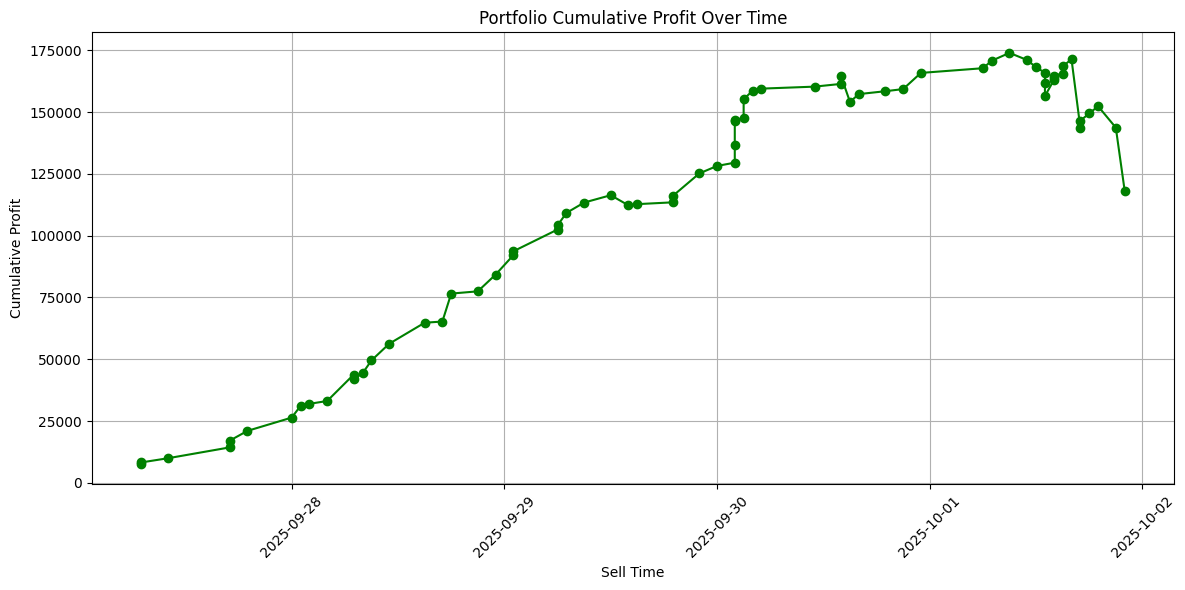

In [ ]:

# Sort by sell_time
df = mean_reversion_trades_df.sort_values("sell_time")

# Compute cumulative profit
df["cumulative_profit"] = df["net_profit"].cumsum()

# Plot
plt.figure(figsize=(12,6))
plt.plot(df["sell_time"], df["cumulative_profit"], marker="o", linestyle="-", color="green")
plt.title("Portfolio Cumulative Profit Over Time")
plt.xlabel("Sell Time")
plt.ylabel("Cumulative Profit")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## **Rolling Average Strategy**

Trend Following / Momentum. Buy assets that are already moving up and sell when the trend reverses.

In [ ]:
def strategy_rolling_average_dip(market_prices_df, short_window=5, long_window=20, min_buy=10000):
    # 1. Sort by time
    df_sorted = market_prices_df.sort_values('sale_time')

    # 2. Calculate rolling metrics grouped by card_id
    grouped = df_sorted.groupby('card_id')
    df_sorted['SMA'] = grouped['sold_price'].transform(
        lambda x: x.rolling(window=short_window, min_periods=1).mean().shift(1)
    )
    df_sorted['LMA'] = grouped['sold_price'].transform(
        lambda x: x.rolling(window=long_window, min_periods=1).mean().shift(1)
    )

    # 3. Take the last available row per card
    last_known_data = df_sorted.groupby('card_id').tail(1).reset_index(drop=True)

    # 4. Strategy logic for dip buying
    is_valid = last_known_data['LMA'].notna() & last_known_data['SMA'].notna()
    is_below_lma = last_known_data['sold_price'] < last_known_data['LMA'] * 0.95  # 5% dip
    is_near_sma = last_known_data['sold_price'] <= last_known_data['SMA'] * 1.02   # not too high
    meets_criteria = is_valid & is_below_lma & is_near_sma

    # 5. Filter by min_buy
    buy_signals = last_known_data[meets_criteria & (last_known_data['sold_price'] >= min_buy)]

    return buy_signals[['card_id', 'name', 'sold_price', 'SMA', 'LMA']]

def strategy_smart_dip(market_prices_df, short_window=5, long_window=20, min_buy=10000):
    # 1. Sort by time
    df_sorted = market_prices_df.sort_values('sale_time')

    # 2. Calculate rolling metrics grouped by card_id
    grouped = df_sorted.groupby('card_id')
    df_sorted['SMA'] = grouped['sold_price'].transform(
        lambda x: x.rolling(window=short_window, min_periods=1).mean().shift(1)
    )
    df_sorted['LMA'] = grouped['sold_price'].transform(
        lambda x: x.rolling(window=long_window, min_periods=1).mean().shift(1)
    )
    df_sorted['momentum'] = grouped['sold_price'].transform(
        lambda x: x.diff(1)  # recent price change
    )

    # 3. Take last row per card
    last_known_data = df_sorted.groupby('card_id').tail(1).reset_index(drop=True)

    # 4. Strategy logic for smart dip
    is_valid = last_known_data['LMA'].notna() & last_known_data['SMA'].notna()
    
    # Buy if price dipped below long-term average
    is_below_lma = last_known_data['sold_price'] < last_known_data['LMA'] * 0.95
    
    # Only buy if short-term momentum is not strongly negative (avoid falling knife)
    safe_momentum = last_known_data['momentum'] >= -0.03 * last_known_data['LMA']  # max 3% drop last sale
    
    # Optional: price near SMA (not too far above)
    near_sma = last_known_data['sold_price'] <= last_known_data['SMA'] * 1.02

    meets_criteria = is_valid & is_below_lma & safe_momentum & near_sma

    # 5. Filter by min_buy

    last_known_data['buy_price'] = last_known_data['sold_price'] 
    buy_signals = last_known_data[meets_criteria & (last_known_data['sold_price'] >= min_buy)]

    return buy_signals[['card_id', 'name', 'buy_price', 'SMA', 'LMA', 'momentum']]

bt = Backtester(df_window, tax=0.05, min_buy=10000, max_buy=500000)
trades_df = bt.run_backtest(strategy_smart_dip, sell_rule_smart)

print(tabulate(trades_df.head(50), headers="keys", tablefmt="pretty", showindex=False))
print("Total Profit:", trades_df['net_profit'].sum() if not trades_df.empty else 0.0)

KeyboardInterrupt: 

## **Momentum Trading Strategy (Short-Term Trend Following Model)**

In [ ]:
min_pct_rise = 0.05
min_sales_for_liquidity=10
short_window=5
long_window = 15
patience=3

def momentum_strategy(market_prices_df):
    df_sorted = market_prices_df.sort_values('sale_time', ascending=False)
    grouped = df_sorted.groupby('card_id')
    
    # --- Moving averages ---
    df_sorted['SMA'] = grouped['sold_price'].transform(
        lambda x: x.rolling(window=short_window, min_periods=1).mean().shift(1)
    )
    df_sorted['LMA'] = grouped['sold_price'].transform(
        lambda x: x.rolling(window=long_window, min_periods=1).mean().shift(1)
    )

    # --- Floor (recent low) + liquidity ---
    df_sorted['recent_low'] = grouped['sold_price'].transform(
        lambda x: x.rolling(window=long_window * 2, min_periods=1).min().shift(1)
    )
    df_sorted['recent_sales_count'] = grouped['sold_price'].transform(
        lambda x: x.rolling(window=long_window, min_periods=1).count().shift(1)
    )

    # --- Entry conditions ---
    is_momentum_up = df_sorted['SMA'] > df_sorted['LMA']
    is_momentum_up &= df_sorted['SMA'].diff() > 0  # SMA is increasing
    df_sorted['pct_rise'] = (df_sorted['sold_price'] - df_sorted['recent_low']) / df_sorted['recent_low']
    is_sufficient_rise = df_sorted['pct_rise'] >= min_pct_rise
    is_liquid = df_sorted['recent_sales_count'] >= min_sales_for_liquidity
    is_valid_data = df_sorted['LMA'].notna()

    df_sorted['buy_signal'] = is_momentum_up & is_sufficient_rise & is_liquid & is_valid_data
    
    # --- Profit target baseline ---
    df_sorted['buy_price'] = df_sorted['sold_price']
    df_sorted['target_sell_raw'] = df_sorted['buy_price'] * 1.05  # 5% gross profit target
    


    # --- Collapse to last known per card ---
    buy_candidates = df_sorted[df_sorted['buy_signal']].copy()
    if buy_candidates.empty:
        return pd.DataFrame(columns=['card_id','name','buy_price','SMA','LMA','pct_rise','target_sell_raw'])

    # Score and pick best per card
    buy_candidates['score'] = buy_candidates['pct_rise'] * buy_candidates['recent_sales_count']
    buy_signals = buy_candidates.sort_values('score', ascending=False)



    return buy_signals[['card_id','name','buy_price','SMA','LMA','pct_rise','target_sell_raw']]



def momentum_exit(card_id, current_price, buy_price, market_df, state):
    """
    - Partial at +10%
    - Trailing stop at -20% from peak
    - Trend exit if under LMA for N bars
    - Adds patience so it won't sell instantly at flat prices
    """

    if card_id not in state:
        state[card_id] = {
            "peak": buy_price,
            "partial_taken": False,
            "below_lma_count": 0
        }

    info = state[card_id]

    # Update peak
    info["peak"] = max(info["peak"], current_price)

    # --- Partial profit ---
    if not info["partial_taken"] and current_price >= 1.10 * buy_price:
        info["partial_taken"] = True
        return "partial"

    # --- Trailing stop-loss ---
    if current_price <= info["peak"] * 0.80:
        return True

    # --- Trend exit with patience ---
    df_sorted = market_df.sort_values('sale_time')
    grouped = df_sorted.groupby('card_id')
    df_sorted['LMA'] = grouped['sold_price'].transform(
        lambda x: x.rolling(window=25, min_periods=1).mean().shift(1)
    )

    last_lma = df_sorted[df_sorted['card_id'] == card_id]['LMA'].iloc[-1]

    if current_price < last_lma:
        info["below_lma_count"] += 1
    else:
        info["below_lma_count"] = 0

    if info["below_lma_count"] >= patience:  
        return True  # exit only if trend reversal persists

    return False

bt = Backtester(df_clean, tax=0.05, min_buy=10000, max_buy=500000)
momentum_trades_df = bt.run_backtest(momentum_strategy, momentum_exit)

print(tabulate(momentum_trades_df.head(50), headers="keys", tablefmt="pretty", showindex=False))
print("Total Profit:", momentum_trades_df['net_profit'].sum() if not momentum_trades_df.empty else 0.0)

NameError: name 'Backtester' is not defined

## **Z-Score Mean Reversion Strategy**

In [ ]:
Z_SCORE_BUY_THRESHOLD = -1.3

def calculate_rebound_flag(x: pd.Series, window: int = 10) -> bool:
    """
    Checks if the last 'window' prices show a net upward momentum (e.g., 
    more than 50% of the steps were increases).
    """
    if len(x) < window:
        return False
    
    # Slice the last 'window' prices
    y = x.tail(window).values 
    
    # Count how many steps were increases (y[i] < y[i+1])
    # Returns True if at least window/2 + 1 steps were increases
    increase_count = sum(y[i] < y[i+1] for i in range(len(y) - 1))
    
    # We require a majority of steps to be increasing for a flexible rebound
    required_increases = int((window - 1) / 2) + 1
    
    return increase_count >= required_increases

def sell_rule_smart(card_id, current_price, buy_price, market_df):
    # 2. Profit/stop-loss
    if current_price >= 1.10 * buy_price:  # 10% profit
        return True
    if current_price <= 0.9 * buy_price:  # 10% loss
        return True
    # 3. Check rebound
    recent = market_df[market_df['card_id']==card_id].tail(20)['sold_price']
    if current_price * 0.95 > recent.median() and current_price * 0.95 > buy_price:
        return True
    return False


def z_score_mean_reversion_strategy(market_prices_df, lookback_short=3, lookback_long=16):
    df_sorted = market_prices_df.sort_values('sale_time')
    latest_time = df_sorted['sale_time'].max()

    long_cutoff_time = latest_time - timedelta(hours=lookback_long)
    short_cutoff_time = latest_time - timedelta(hours=lookback_short)

    short_df = df_sorted[df_sorted['sale_time'] >= short_cutoff_time]
    long_df = df_sorted[df_sorted['sale_time'] >= long_cutoff_time]


    short_mean_series = short_df.groupby('card_id')['sold_price'].mean()
    short_median_series = short_df.groupby('card_id')['sold_price'].median()
    long_mean_series = long_df.groupby('card_id')['sold_price'].mean()
    std_dev_series = long_df.groupby('card_id')['sold_price'].std()
    liquid_series = short_df.groupby('card_id')['sold_price'].count()

    valid_card_ids = short_mean_series.index.intersection(long_mean_series.index)
    latest_data = df_sorted.groupby('card_id').tail(1).copy()
    latest_data = latest_data[latest_data['card_id'].isin(valid_card_ids)].copy()

    # Historical Data

    rebound_series = short_df.groupby('card_id')['sold_price'].apply(
        lambda x: calculate_rebound_flag(x, window=5)
    )

    epsilon = 1e-9
    latest_data['short_mean'] = latest_data['card_id'].map(short_mean_series)
    latest_data['short_median'] = latest_data['card_id'].map(short_median_series)
    latest_data['long_mean'] = latest_data['card_id'].map(long_mean_series)
    latest_data['std_dev'] = latest_data['card_id'].map(std_dev_series)
    latest_data['rebound_flag'] = latest_data['card_id'].map(rebound_series)
    latest_data['liquid'] = latest_data['card_id'].map(liquid_series)

    latest_data['z_score'] = (latest_data['short_median'] - latest_data['long_mean']) / (latest_data['std_dev'] + epsilon)
    latest_data['z_score'] = latest_data['z_score'].fillna(999) 
    latest_data['discount_pct'] = ((latest_data['long_mean'] - latest_data['short_median']) / latest_data['long_mean'] * 100)

    


    z_score_mask = latest_data['z_score'] <= Z_SCORE_BUY_THRESHOLD
    liquid_mask = latest_data['liquid'] >= 2

    final_buy_mask = z_score_mask & liquid_mask 

    # Select the final list of potential buys
    latest_data['score'] = latest_data['discount_pct'] / 100 - latest_data['z_score']
    final_candidates = latest_data[final_buy_mask].sort_values('score', ascending=False)

    final_candidates['buy_price'] = final_candidates['short_median']
    signal_cutoff = latest_time - timedelta(hours=2)
    final_candidates = final_candidates[final_candidates['sale_time'] >= signal_cutoff]
    return final_candidates


df_clean_full_pc = df_window[
    (df_window['platform'] == "pc") & 
    (df_window['version'].notna())
].copy()

# Live 
candidates = z_score_mean_reversion_strategy(df_clean_full_pc)
print(tabulate(candidates.head(50), headers="keys", tablefmt="pretty", showindex=False))

# Backtesting
# bt = Backtester(df_clean_full_pc, tax=0.05, min_buy=20000, max_buy=400000)
# z_score_strat_df = bt.run_backtest(z_score_mean_reversion_strategy, sell_rule_smart)
# print(tabulate(z_score_strat_df.head(50), headers="keys", tablefmt="pretty", showindex=False))
# print("Total Profit:", z_score_strat_df['net_profit'].sum() if not z_score_strat_df.empty else 0.0)


+----------+---------+----------+-----------+---------------------+--------------+------------+----------+----------------------------------+--------+------------------+----------+------------------+------------------+-------------------+--------------+--------------------+--------------------+--------------+--------+---------------------+--------------------+--------------------+-----------+
| sale_id  | card_id | platform | sale_type |      sale_time      | listed_price | sold_price | was_sold |               name               | rating |     version      | position | current_ps_price | current_pc_price |    short_mean     | short_median |     long_mean      |      std_dev       | rebound_flag | liquid |       z_score       |    discount_pct    |       score        | buy_price |
+----------+---------+----------+-----------+---------------------+--------------+------------+----------+----------------------------------+--------+------------------+----------+------------------+---------

In [ ]:
from datetime import timedelta
import pandas as pd
import numpy as np

def Max_Drop_Aggressive_Buy_Relaxed(market_prices_df, short_window=6, long_window=24, dip_threshold=0.09):
    """
    Buys cards when the price is at a significant discount (dip_threshold) compared 
    to the long-term mean. This version relaxes the threshold for stability.
    """
    df_sorted = market_prices_df.sort_values('sale_time')
    latest_time = df_sorted['sale_time'].max()
    
    if df_sorted.empty or df_sorted.shape[0] < 5:
        return pd.DataFrame(columns=['card_id', 'buy_price', 'confidence'])
        
    long_cutoff_time = latest_time - timedelta(hours=long_window)
    short_cutoff_time = latest_time - timedelta(hours=short_window)
    
    short_df = df_sorted[df_sorted['sale_time'] >= short_cutoff_time]
    long_df = df_sorted[df_sorted['sale_time'] >= long_cutoff_time]
    
    # Compute essential stats
    long_mean = long_df.groupby('card_id')['sold_price'].mean()
    short_volume = short_df.groupby('card_id')['sold_price'].count()
    
    latest_data = df_sorted.groupby('card_id').tail(1).copy()
    
    # Map metrics
    latest_data['long_mean'] = latest_data['card_id'].map(long_mean)
    latest_data['short_volume'] = latest_data['card_id'].map(short_volume)
    
    # Filter for valid data
    latest_data.dropna(subset=['long_mean', 'short_volume'], inplace=True)

    if latest_data.empty: return pd.DataFrame(columns=['card_id', 'buy_price', 'confidence'])
    
    # 1. DEEP DISCOUNT CHECK (Using the relaxed threshold of 0.06)
    latest_data['drop_pct'] = (latest_data['long_mean'] - latest_data['sold_price']) / (latest_data['long_mean'] + 1e-9)
    deep_discount_mask = (latest_data['drop_pct'] >= dip_threshold)
    
    # 2. LIQUIDITY CHECK (Minimum required volume)
    liquidity_mask = latest_data['short_volume'] >= 5
    
    # Final mask
    buy_mask = (
        deep_discount_mask &
        liquidity_mask
    )
    
    signals = latest_data[buy_mask].copy()
    signals['buy_price'] = signals['sold_price'] 
    signals['confidence'] = signals['drop_pct'] 
    
    return signals.sort_values('confidence', ascending=False)

df_clean_full_pc = df_window[
    (df_window['platform'] == "pc") & 
    (df_window['version'].notna())
].copy()

candidates = Max_Drop_Aggressive_Buy_Relaxed(df_clean_full_pc)
print(tabulate(candidates.head(50), headers="keys", tablefmt="pretty", showindex=False))

# bt = Backtester(df_clean_full_pc, tax=0.05, min_buy=30000, max_buy=300000)
# buy_the_dip_strategy_df = bt.run_backtest(Max_Drop_Aggressive_Buy_Relaxed, sell_rule_smart)
# print(tabulate(buy_the_dip_strategy_df.head(50), headers="keys", tablefmt="pretty", showindex=False))
# print("Total Profit:", buy_the_dip_strategy_df['net_profit'].sum() if not buy_the_dip_strategy_df.empty else 0.0)

+----------+---------+----------+-----------+---------------------+--------------+------------+----------+--------------+--------+-----------+----------+------------------+------------------+-------------------+--------------+---------------------+-----------+---------------------+
| sale_id  | card_id | platform | sale_type |      sale_time      | listed_price | sold_price | was_sold |     name     | rating |  version  | position | current_ps_price | current_pc_price |     long_mean     | short_volume |      drop_pct       | buy_price |     confidence      |
+----------+---------+----------+-----------+---------------------+--------------+------------+----------+--------------+--------+-----------+----------+------------------+------------------+-------------------+--------------+---------------------+-----------+---------------------+
| 32258772 |  18750  |    pc    |  Buy Now  | 2025-10-16 07:26:00 |    110000    |   110000   |    1     | Gary Lineker |   89   | All Icons |    ST   

In [ ]:
def Deep_Dip_Buy_Volume_Confirm(market_prices_df, short_window=4, long_window=24, dip_threshold=0.09):
    """
    Buy cards that have crashed recently and are near the low,
    but only if the trading volume has stabilized (not in a panic spike).
    """
    df_sorted = market_prices_df.sort_values('sale_time')
    latest_time = df_sorted['sale_time'].max()
    
    if df_sorted.empty or df_sorted.shape[0] < 5:
        return pd.DataFrame(columns=['card_id', 'buy_price', 'confidence'])
        
    long_cutoff_time = latest_time - timedelta(hours=long_window)
    short_cutoff_time = latest_time - timedelta(hours=short_window)
    
    short_df = df_sorted[df_sorted['sale_time'] >= short_cutoff_time]
    long_df = df_sorted[df_sorted['sale_time'] >= long_cutoff_time]
    
    # Compute stats
    long_mean = long_df.groupby('card_id')['sold_price'].mean()
    short_mean = short_df.groupby('card_id')['sold_price'].mean()
    long_volume = long_df.groupby('card_id')['sold_price'].count()
    short_volume = short_df.groupby('card_id')['sold_price'].count()
    
    latest_data = df_sorted.groupby('card_id').tail(1).copy()
    latest_data['long_mean'] = latest_data['card_id'].map(long_mean)
    latest_data['short_low_mean'] = latest_data['card_id'].map(short_mean) # Renamed to avoid confusion
    latest_data['short_volume'] = latest_data['card_id'].map(short_volume)
    
    # Calculate average hourly volume for the long window
    latest_data['long_avg_hourly_volume'] = latest_data['card_id'].map(long_volume) / long_window
    latest_data['short_avg_hourly_volume'] = latest_data['card_id'].map(short_volume) / short_window
    
    # Key Buy Conditions
    latest_data['drop_pct'] = (latest_data['long_mean'] - latest_data['sold_price']) / (latest_data['long_mean'] + 1e-9)
    
    # 1. Near Low: Buy if price is near the short-term average (proxy for near the low)
    latest_data['near_low_mask'] = (latest_data['sold_price'] <= 1.05 * latest_data['short_low_mean'])
    
    # 2. Volume Stability (CRITICAL ADDITION): Short-term volume should not be excessive
    # Ensures we are not buying during peak panic selling.
    latest_data['volume_stable_mask'] = (
        latest_data['short_avg_hourly_volume'] <= 1.25 * latest_data['long_avg_hourly_volume']
    )
    
    # 3. Liquidity Check: Ensure minimum trades to avoid stale prices
    latest_data['liquid_mask'] = (latest_data['short_volume'] >= 5) 

    buy_mask = (
        (latest_data['drop_pct'] >= dip_threshold) & 
        latest_data['near_low_mask'] & 
        latest_data['volume_stable_mask'] & 
        latest_data['liquid_mask']
    )
    
    signals = latest_data[buy_mask].copy()
    signals['buy_price'] = signals['sold_price']
    signals['confidence'] = signals['drop_pct'] 
    
    return signals.sort_values('confidence', ascending=False)

df_clean_full_pc = df_window[
    (df_window['platform'] == "pc") & 
    (df_window['version'].notna())
].copy()

# Live 
candidates = Deep_Dip_Buy_Volume_Confirm(df_clean_full_pc)
print(tabulate(candidates.head(50), headers="keys", tablefmt="pretty", showindex=False))

# Backtesting
# bt = Backtester(df_clean_full_pc, tax=0.05, min_buy=30000, max_buy=400000)
# buy_the_dip_strategy_df = bt.run_backtest(Deep_Dip_Buy_Volume_Confirm, sell_rule_smart)
# print(tabulate(buy_the_dip_strategy_df.head(50), headers="keys", tablefmt="pretty", showindex=False))
# print("Total Profit:", buy_the_dip_strategy_df['net_profit'].sum() if not buy_the_dip_strategy_df.empty else 0.0)

+---------+---------+----------+-----------+-----------+--------------+------------+----------+------+--------+---------+----------+------------------+------------------+-----------+----------------+--------------+------------------------+-------------------------+----------+---------------+--------------------+-------------+-----------+------------+
| sale_id | card_id | platform | sale_type | sale_time | listed_price | sold_price | was_sold | name | rating | version | position | current_ps_price | current_pc_price | long_mean | short_low_mean | short_volume | long_avg_hourly_volume | short_avg_hourly_volume | drop_pct | near_low_mask | volume_stable_mask | liquid_mask | buy_price | confidence |
+---------+---------+----------+-----------+-----------+--------------+------------+----------+------+--------+---------+----------+------------------+------------------+-----------+----------------+--------------+------------------------+-------------------------+----------+---------------+--

In [ ]:
def Deep_Dip_Buy_Volume_Confirm(market_prices_df, platform="pc", short_window=4, long_window=24, dip_threshold=0.09):
    """
    Buy cards that have crashed recently and are near the low,
    but only if the trading volume has stabilized (not in a panic spike).
    """
    df_sorted = market_prices_df.sort_values('sale_time')
    latest_time = df_sorted['sale_time'].max()
    
    if df_sorted.empty or df_sorted.shape[0] < 5:
        return pd.DataFrame(columns=['card_id', 'buy_price', 'confidence'])
        
    long_cutoff_time = latest_time - timedelta(hours=long_window)
    short_cutoff_time = latest_time - timedelta(hours=short_window)
    
    short_df = df_sorted[df_sorted['sale_time'] >= short_cutoff_time]
    long_df = df_sorted[df_sorted['sale_time'] >= long_cutoff_time]
    
    # Compute stats
    long_mean = long_df.groupby('card_id')['sold_price'].mean()
    short_mean = short_df.groupby('card_id')['sold_price'].mean()
    long_volume = long_df.groupby('card_id')['sold_price'].count()
    short_volume = short_df.groupby('card_id')['sold_price'].count()
    
    latest_data = df_sorted.groupby('card_id').tail(1).copy()
    latest_data['long_mean'] = latest_data['card_id'].map(long_mean)
    latest_data['short_low_mean'] = latest_data['card_id'].map(short_mean) # Renamed to avoid confusion
    latest_data['short_volume'] = latest_data['card_id'].map(short_volume)
    
    # Calculate average hourly volume for the long window
    latest_data['long_avg_hourly_volume'] = latest_data['card_id'].map(long_volume) / long_window
    latest_data['short_avg_hourly_volume'] = latest_data['card_id'].map(short_volume) / short_window
    
    # Key Buy Conditions
    latest_data['drop_pct'] = (latest_data['long_mean'] - latest_data[f'current_{platform}_price']) / (latest_data['long_mean'] + 1e-9)
    
    # 1. Near Low: Buy if price is near the short-term average (proxy for near the low)
    latest_data['near_low_mask'] = (latest_data['short_low_mean'] <= 1.05 * latest_data[f'current_{platform}_price'])
    
    # 2. Volume Stability (CRITICAL ADDITION): Short-term volume should not be excessive
    # Ensures we are not buying during peak panic selling.
    latest_data['volume_stable_mask'] = (
        latest_data['short_avg_hourly_volume'] <= 1.25 * latest_data['long_avg_hourly_volume']
    )
    
    # 3. Liquidity Check: Ensure minimum trades to avoid stale prices
    latest_data['liquid_mask'] = (latest_data['short_volume'] >= 5) 


    buy_mask = (
        (latest_data["drop_pct"] >= dip_threshold)
        & latest_data["near_low_mask"]
        & latest_data["volume_stable_mask"]
        & latest_data["liquid_mask"]
        & latest_data["history_mask"]
        & latest_data["confirm_mask"]  # only buy if stabilized
    )
    
    signals = latest_data[buy_mask].copy()
    signals['confidence'] = signals['drop_pct'] 
    
    return signals.sort_values('confidence', ascending=False)

df_clean_full_pc = df_window[
    (df_window['platform'] == "pc") & 
    (df_window['version'].notna())
].copy()

candidates = Deep_Dip_Buy_Volume_Confirm(df_clean_full_pc)
print(tabulate(candidates.head(50), headers="keys", tablefmt="pretty", showindex=False))

+----------+---------+----------+-----------+---------------------+--------------+------------+----------+----------------------------------+--------+-----------+----------+------------------+------------------+------------------+--------------------+--------------+------------------------+-------------------------+---------------------+---------------+--------------------+-------------+---------------------+
| sale_id  | card_id | platform | sale_type |      sale_time      | listed_price | sold_price | was_sold |               name               | rating |  version  | position | current_ps_price | current_pc_price |    long_mean     |   short_low_mean   | short_volume | long_avg_hourly_volume | short_avg_hourly_volume |      drop_pct       | near_low_mask | volume_stable_mask | liquid_mask |     confidence      |
+----------+---------+----------+-----------+---------------------+--------------+------------+----------+----------------------------------+--------+-----------+----------+-

## Crash Friendly Version

In [ ]:
def sell_rule_smart(card_id, current_price, buy_price, market_df):
    # 2. Profit/stop-loss
    if current_price >= 1.10 * buy_price:  # 10% profit
        return True
    if current_price <= 0.9 * buy_price:  # 10% loss
        return True
    # 3. Check rebound
    recent = market_df[market_df['card_id']==card_id].tail(20)['sold_price']
    if current_price * 0.95 > recent.median() and current_price * 0.95 > buy_price:
        return True
    return False

def Deep_Dip_Buy_Volume_Confirm(
    market_prices_df, short_window=4, long_window=24, dip_threshold=0.09
):
    """
    Buy cards that have crashed recently and are near the low,
    but only if the trading volume has stabilized (not in a panic spike),
    and the price is no longer trending down sharply.
    """
    df_sorted = market_prices_df.sort_values("sale_time")
    latest_time = df_sorted["sale_time"].max()

    if df_sorted.empty or df_sorted.shape[0] < 5:
        return pd.DataFrame(columns=["card_id", "buy_price", "confidence"])

    long_cutoff_time = latest_time - timedelta(hours=long_window)
    short_cutoff_time = latest_time - timedelta(hours=short_window)
    one_hr_cutoff_time = latest_time - timedelta(hours=1)

    short_df = df_sorted[df_sorted["sale_time"] >= short_cutoff_time]
    long_df = df_sorted[df_sorted["sale_time"] >= long_cutoff_time]
    one_hr_df = df_sorted[df_sorted["sale_time"] >= one_hr_cutoff_time]

    # --- Compute means and volumes ---
    long_mean = long_df.groupby("card_id")["sold_price"].mean()
    short_mean = short_df.groupby("card_id")["sold_price"].mean()
    one_hr_mean = one_hr_df.groupby("card_id")["sold_price"].mean()

    long_volume = long_df.groupby("card_id")["sold_price"].count()
    short_volume = short_df.groupby("card_id")["sold_price"].count()

    latest_data = df_sorted.groupby("card_id").tail(1).copy()
    latest_data["long_mean"] = latest_data["card_id"].map(long_mean)
    latest_data["short_mean"] = latest_data["card_id"].map(short_mean)
    latest_data["one_hr_mean"] = latest_data["card_id"].map(one_hr_mean)
    latest_data["short_volume"] = latest_data["card_id"].map(short_volume)

    # --- Volume stability ---
    latest_data["long_avg_hourly_volume"] = (
        latest_data["card_id"].map(long_volume) / long_window
    )
    latest_data["short_avg_hourly_volume"] = (
        latest_data["card_id"].map(short_volume) / short_window
    )

    # --- Drop from 24h mean ---
    latest_data["drop_pct"] = (
        (latest_data["long_mean"] - latest_data["sold_price"])
        / (latest_data["long_mean"] + 1e-9)
    )

    # --- 1. Near the low (buy near recent bottom) ---
    latest_data["near_low_mask"] = (
        latest_data["sold_price"] <= 1.03 * latest_data["short_mean"]
    )

    # --- 2. Volume stability (avoid panic dump) ---
    latest_data["volume_stable_mask"] = (
        latest_data["short_avg_hourly_volume"]
        <= 1.25 * latest_data["long_avg_hourly_volume"]
    )

    # --- 3. Liquidity filter ---
    latest_data["liquid_mask"] = latest_data["short_volume"] >= 5

    # --- 4. Avoid continuous crashes ---
    latest_data["stabilizing_mask"] = (
        latest_data["short_mean"] >= 0.97 * latest_data["long_mean"]
    )

    # --- 5. Allow quick rebound dips (price rising in last hour) ---
    latest_data["rebound_mask"] = (
        latest_data["sold_price"] > 1.02 * latest_data["one_hr_mean"]
    )

    # --- Combined buy mask ---
    buy_mask = (
        (latest_data["drop_pct"] >= dip_threshold)
        & latest_data["near_low_mask"]
        & latest_data["volume_stable_mask"]
        & latest_data["liquid_mask"]
        & (latest_data["rebound_mask"] | latest_data["stabilizing_mask"])
    )

    signals = latest_data[buy_mask].copy()
    signals["buy_price"] = signals["sold_price"]
    signals["confidence"] = signals["drop_pct"]

    return signals.sort_values("confidence", ascending=False)


df_clean_full_pc = df_window[
    (df_window['platform'] == "pc") & 
    (df_window['version'].notna())
].copy()

# Live 
# candidates = Deep_Dip_Buy_Volume_Confirm(df_clean_full_pc)
# print(tabulate(candidates.head(50), headers="keys", tablefmt="pretty", showindex=False))

# Backtesting
bt = Backtester(df_clean_full_pc, tax=0.05, min_buy=30000, max_buy=10000000)
buy_the_dip_strategy_df = bt.run_backtest(Deep_Dip_Buy_Volume_Confirm, sell_rule_smart)
print(tabulate(buy_the_dip_strategy_df.head(200), headers="keys", tablefmt="pretty", showindex=False))
print("Total Profit:", buy_the_dip_strategy_df['net_profit'].sum() if not buy_the_dip_strategy_df.empty else 0.0)

+----------+---------+----------+-----------+---------------------+--------------+------------+----------+---------------------+--------+-----------+----------+------------------+------------------+--------------------+-------------------+-------------------+--------------+------------------------+-------------------------+---------------------+---------------+--------------------+-------------+------------------+--------------+-----------+---------------------+
| sale_id  | card_id | platform | sale_type |      sale_time      | listed_price | sold_price | was_sold |        name         | rating |  version  | position | current_ps_price | current_pc_price |     long_mean      |    short_mean     |    one_hr_mean    | short_volume | long_avg_hourly_volume | short_avg_hourly_volume |      drop_pct       | near_low_mask | volume_stable_mask | liquid_mask | stabilizing_mask | rebound_mask | buy_price |     confidence      |
+----------+---------+----------+-----------+---------------------

In [ ]:
def Deep_Dip_Buy_Volume_Confirm(
    market_prices_df,
    platform="pc",
    short_window=4,
    long_window=24,
    dip_threshold=0.09,
    min_history_hours=96,
    confirm_window=1  # hours to confirm stabilization
):
    """
    Buy cards that have crashed recently and are near the low,
    but only if:
      - the price is stabilizing (not mid-crash)
      - volume is reasonable
      - the card has sufficient trading history

    confirm_window: short period to confirm crash has stopped
    """
    df_sorted = market_prices_df.sort_values("sale_time")
    latest_time = df_sorted["sale_time"].max()

    if df_sorted.empty or df_sorted.shape[0] < 5:
        return pd.DataFrame()

    long_cutoff = latest_time - timedelta(hours=long_window)
    short_cutoff = latest_time - timedelta(hours=short_window)
    confirm_cutoff = latest_time - timedelta(hours=confirm_window)
    min_history = timedelta(hours=min_history_hours)

    # Short, long, and confirm periods
    long_df = df_sorted[df_sorted["sale_time"] >= long_cutoff]
    short_df = df_sorted[df_sorted["sale_time"] >= short_cutoff]
    confirm_df = df_sorted[df_sorted["sale_time"] >= confirm_cutoff]

    # Compute stats
    long_mean = long_df.groupby("card_id")["sold_price"].mean()
    short_low = short_df.groupby("card_id")["sold_price"].min()
    long_volume = long_df.groupby("card_id")["sold_price"].count()
    short_volume = short_df.groupby("card_id")["sold_price"].count()
    first_sale_time = df_sorted.groupby("card_id")["sale_time"].min()

    latest_data = df_sorted.groupby("card_id").tail(1).copy()

    # Map stats
    latest_data["long_mean"] = latest_data["card_id"].map(long_mean)
    latest_data["short_low"] = latest_data["card_id"].map(short_low)
    latest_data["short_volume"] = latest_data["card_id"].map(short_volume)
    latest_data["first_sale_time"] = latest_data["card_id"].map(first_sale_time)
    latest_data["long_avg_hourly_volume"] = latest_data["card_id"].map(long_volume) / long_window
    latest_data["short_avg_hourly_volume"] = latest_data["card_id"].map(short_volume) / short_window

    # Drop cards without long_mean
    latest_data.dropna(subset=["long_mean"], inplace=True)

    # --- Drop relative to long-term mean ---
    latest_data["drop_pct"] = (latest_data["long_mean"] - latest_data[f"current_{platform}_price"]) / latest_data["long_mean"]

    # --- Near low (compared to recent short-term minimum) ---
    latest_data["near_low_mask"] = latest_data[f"current_{platform}_price"] <= 1.05 * latest_data["short_low"]

    # --- Volume stability ---
    latest_data["volume_stable_mask"] = np.where(
        latest_data[f"current_{platform}_price"] > 200_000,
        latest_data["short_avg_hourly_volume"] <= 2.0 * latest_data["long_avg_hourly_volume"],
        latest_data["short_avg_hourly_volume"] <= 1.25 * latest_data["long_avg_hourly_volume"]
    )

    # --- Liquidity check ---
    latest_data["liquid_mask"] = np.where(
        latest_data[f"current_{platform}_price"] > 200_000,
        latest_data["short_volume"] >= 2,
        latest_data["short_volume"] >= 5
    )

    # --- History filter ---
    latest_data["history_mask"] = (latest_time - latest_data["first_sale_time"] >= min_history)

    # --- Short-window confirmation: price should have stabilized recently ---
    confirm_min = confirm_df.groupby("card_id")["sold_price"].min()
    latest_data["confirm_mask"] = latest_data[f"current_{platform}_price"] >= latest_data["card_id"].map(confirm_min)
    
    # --- Final buy mask ---
    buy_mask = (
        (latest_data["drop_pct"] >= dip_threshold)
        & latest_data["near_low_mask"]
        & latest_data["volume_stable_mask"]
        & latest_data["liquid_mask"]
        & latest_data["history_mask"]
        & latest_data["confirm_mask"]  # only buy if stabilized
    )

    signals = latest_data[buy_mask].copy()
    signals["confidence"] = signals["drop_pct"]
    signals["buy_price"] = signals[f"current_{platform}_price"]

    return signals.sort_values("confidence", ascending=False)


df_clean_full_pc = df_window[
    (df_window['platform'] == "pc") & 
    (df_window['version'].notna())
].copy()

# Live 
candidates = Deep_Dip_Buy_Volume_Confirm(df_clean_full_pc)
print(tabulate(candidates.head(50), headers="keys", tablefmt="pretty", showindex=False))

# Backtesting
# bt = Backtester(df_clean_full_pc, tax=0.05, min_buy=30000, max_buy=10000000)
# buy_the_dip_strategy_df = bt.run_backtest(Deep_Dip_Buy_Volume_Confirm, sell_rule_smart)
# print(tabulate(buy_the_dip_strategy_df.head(200), headers="keys", tablefmt="pretty", showindex=False))
# print("Total Profit:", buy_the_dip_strategy_df['net_profit'].sum() if not buy_the_dip_strategy_df.empty else 0.0)

+----------+---------+----------+-----------+---------------------+--------------+------------+----------+----------------+--------+-----------------+----------+------------------+------------------+-------------------+-----------+--------------+---------------------+------------------------+-------------------------+---------------------+---------------+--------------------+-------------+--------------+--------------+---------------------+-----------+
| sale_id  | card_id | platform | sale_type |      sale_time      | listed_price | sold_price | was_sold |      name      | rating |     version     | position | current_ps_price | current_pc_price |     long_mean     | short_low | short_volume |   first_sale_time   | long_avg_hourly_volume | short_avg_hourly_volume |      drop_pct       | near_low_mask | volume_stable_mask | liquid_mask | history_mask | confirm_mask |     confidence      | buy_price |
+----------+---------+----------+-----------+---------------------+--------------+----

## **Volume-Confirmed Reversal Detection (VCRD) Strategy**

Identifies the end-of-downtrend conditions using a two-stage higher-low pattern, volume acceleration, and volatility contraction filters.

The model produces a probabilisitic confidence score to time entries during post-crash recoveries.

In [ ]:


def sell_rule_smart(card_id, current_price, buy_price, market_df):
    # 2. Profit/stop-loss
    if current_price >= 1.10 * buy_price:  # 10% profit
        return True
    if current_price <= 0.95 * buy_price:  # 10% loss
        return True
    # 3. Check rebound
    recent = market_df[market_df['card_id']==card_id].tail(20)['sold_price']
    if current_price * 0.95 > recent.median() and current_price * 0.95 > buy_price:
        return True
    return False

def VCRD_Strategy(market_prices_df, short_window=5, long_window=48, min_discount_pct=2, min_profit= 3000):
    """
    Optimized VCRD strategy: buys cards after meaningful dips when early rebound signs appear.
    Filters out low-profit and illiquid signals.
    """
    df_sorted = market_prices_df.sort_values('sale_time')
    latest_time = df_sorted['sale_time'].max()
    epsilon = 1e-9

    # Define short & long periods
    short_df = df_sorted[df_sorted['sale_time'] >= latest_time - timedelta(hours=short_window)]
    long_df = df_sorted[df_sorted['sale_time'] >= latest_time - timedelta(hours=long_window)]

    # EWMA means
    short_ewm = short_df.groupby('card_id')['sold_price'].apply(lambda x: x.ewm(span=short_window).mean().iloc[-1])
    long_ewm = long_df.groupby('card_id')['sold_price'].apply(lambda x: x.ewm(span=long_window).mean().iloc[-1])
    
    # Volatility & recent metrics
    short_low = short_df.groupby('card_id')['sold_price'].min()
    short_high = short_df.groupby('card_id')['sold_price'].max()
    short_std = short_df.groupby('card_id')['sold_price'].std()
    short_volume = short_df.groupby('card_id')['sold_price'].count()

    # Latest snapshot
    latest_data = df_sorted.groupby('card_id').tail(1).copy()
    latest_data['short_mean'] = latest_data['card_id'].map(short_ewm)
    latest_data['long_mean'] = latest_data['card_id'].map(long_ewm)
    latest_data['short_low'] = latest_data['card_id'].map(short_low)
    latest_data['short_high'] = latest_data['card_id'].map(short_high)
    latest_data['short_std'] = latest_data['card_id'].map(short_std)
    latest_data['short_volume'] = latest_data['card_id'].map(short_volume)

    # Derived metrics
    latest_data['rebound_strength'] = (latest_data['short_mean'] - latest_data['short_low']) / ((latest_data['short_high'] - latest_data['short_low']) + epsilon)
    latest_data['recent_change'] = latest_data['short_mean'].pct_change().fillna(0)
    latest_data['discount_pct'] = (latest_data['long_mean'] - latest_data['short_mean']) / (latest_data['long_mean'] + epsilon) * 100
    latest_data['z_score'] = (latest_data['short_mean'] - latest_data['long_mean']) / (latest_data['short_std'] + epsilon)
    latest_data['expected_profit'] = latest_data['long_mean'] * 0.95 - latest_data['short_mean']  # EA 5% tax included

    # Masks
    discount_mask = latest_data['discount_pct'] >= min_discount_pct
    profit_mask = latest_data['expected_profit'] >= min_profit
    z_score_mask = latest_data['z_score'] <= -0.25
    rebound_mask = latest_data['rebound_strength'] >= 0.3
    stability_mask = (latest_data['short_std'] / (latest_data['short_mean'] + epsilon)) <= 0.07
    liquidity_mask = latest_data['short_volume'] >= 3

    final_mask = discount_mask & profit_mask & z_score_mask & rebound_mask & stability_mask & liquidity_mask



    # Confidence score (profit-weighted)
    confidence = (
        0.35 * latest_data['rebound_strength'] +
        0.20 * latest_data['discount_pct'] / 100 +
        0.25 * (latest_data['expected_profit'] / (latest_data['short_mean'] + epsilon)) +
        0.10 * (-latest_data['z_score']) +  # reward deeper dips
        0.10 * (latest_data['short_volume'] / (latest_data['short_volume'].max() + epsilon))
    ).fillna(0)

    signals = latest_data[final_mask].copy()
    signals['confidence'] = confidence[final_mask]
    signals['buy_price'] = signals['short_mean']

    # Only consider most recent sales (last 2 hours)
    signals = signals[signals['sale_time'] >= latest_time - timedelta(hours=2)]
    signals = signals.sort_values('confidence', ascending=False)

    return signals


df_clean_full_pc = df_window[
    (df_window['platform'] == "pc") & 
    (df_window['version'].notna())
].copy()

# Live 
candidates = VCRD_Strategy(df_clean_full_pc)
print(tabulate(candidates.head(50), headers="keys", tablefmt="pretty", showindex=False))

# Backtesting
# bt = Backtester(df_clean_full_pc, tax=0.05, min_buy=30000, max_buy=400000)
# VCRD_strategy_df = bt.run_backtest(VCRD_Strategy, sell_rule_smart)
# print(tabulate(VCRD_strategy_df.head(50), headers="keys", tablefmt="pretty", showindex=False))
# print("Total Profit:", VCRD_strategy_df['net_profit'].sum() if not VCRD_strategy_df.empty else 0.0)

+---------+---------+----------+-----------+-----------+--------------+------------+----------+------+--------+---------+----------+------------------+------------------+------------+-----------+-----------+------------+-----------+--------------+------------------+---------------+--------------+---------+-----------------+------------+-----------+
| sale_id | card_id | platform | sale_type | sale_time | listed_price | sold_price | was_sold | name | rating | version | position | current_ps_price | current_pc_price | short_mean | long_mean | short_low | short_high | short_std | short_volume | rebound_strength | recent_change | discount_pct | z_score | expected_profit | confidence | buy_price |
+---------+---------+----------+-----------+-----------+--------------+------------+----------+------+--------+---------+----------+------------------+------------------+------------+-----------+-----------+------------+-----------+--------------+------------------+---------------+--------------+-

In [ ]:
def sell_rule_smart(card_id, current_price, buy_price, market_df):
    # 2. Profit/stop-loss
    if current_price >= 1.10 * buy_price:  # 10% profit
        return True
    if current_price <= 0.9 * buy_price:  # 10% loss
        return True
    # 3. Check rebound
    recent = market_df[market_df['card_id']==card_id].tail(20)['sold_price']
    if current_price * 0.95 > recent.median() and current_price * 0.95 > buy_price:
        return True
    return False

def Deep_Dip_Buy_Volume_Confirm(
    market_prices_df,
    platform="pc",
    short_window=4,
    long_window=24,
    dip_threshold=0.09,
    min_history_hours=96
):
    """
    Advanced dip-buy strategy with:
      - Momentum smoothing (EMA slope check)
      - Oversupply filter (volume stability)
      - History + liquidity checks
    """
    df_sorted = market_prices_df.sort_values('sale_time')
    if df_sorted.empty or df_sorted.shape[0] < 5:
        return pd.DataFrame()

    latest_time = df_sorted['sale_time'].max()
    long_cutoff_time = latest_time - timedelta(hours=long_window)
    short_cutoff_time = latest_time - timedelta(hours=short_window)
    required_history = timedelta(hours=min_history_hours)

    short_df = df_sorted[df_sorted['sale_time'] >= short_cutoff_time]
    long_df = df_sorted[df_sorted['sale_time'] >= long_cutoff_time]

    # ---- Compute stats ----
    long_mean = long_df.groupby('card_id')['sold_price'].mean()
    short_low = short_df.groupby('card_id')['sold_price'].min()
    long_volume = long_df.groupby('card_id')['sold_price'].count()
    short_volume = short_df.groupby('card_id')['sold_price'].count()
    first_sale_time = df_sorted.groupby('card_id')['sale_time'].min()

    latest_data = df_sorted.groupby('card_id').tail(1).copy()
    latest_data['long_mean'] = latest_data['card_id'].map(long_mean)
    latest_data['short_low'] = latest_data['card_id'].map(short_low)
    latest_data['short_volume'] = latest_data['card_id'].map(short_volume)
    latest_data['first_sale_time'] = latest_data['card_id'].map(first_sale_time)
    latest_data['long_avg_hourly_volume'] = latest_data['card_id'].map(long_volume) / long_window
    latest_data['short_avg_hourly_volume'] = latest_data['card_id'].map(short_volume) / short_window

    latest_data.dropna(subset=['long_mean'], inplace=True)

    # ---- Drop percentage ----
    latest_data['drop_pct'] = (
        (latest_data['long_mean'] - latest_data[f'current_{platform}_price'])
        / (latest_data['long_mean'] + 1e-9)
    )

    # ---- Near low ----
    latest_data['near_low_mask'] = (
        latest_data[f'current_{platform}_price'] <= 1.05 * latest_data['short_low']
    )

    # ---- Volume stability ----
    latest_data['volume_stable_mask'] = np.where(
        latest_data[f'current_{platform}_price'] > 200000,
        latest_data['short_avg_hourly_volume'] <= 2.0 * latest_data['long_avg_hourly_volume'],
        latest_data['short_avg_hourly_volume'] <= 1.25 * latest_data['long_avg_hourly_volume']
    )

    # ---- Liquidity ----
    latest_data['liquid_mask'] = np.where(
        latest_data[f'current_{platform}_price'] > 200000,
        latest_data['short_volume'] >= 2,
        latest_data['short_volume'] >= 5
    )

    # ---- History ----
    latest_data['history_mask'] = (
        latest_time - latest_data['first_sale_time'] >= required_history
    )

    # ---- Momentum smoothing (EMA slope) ----
    df_sorted['ema_short'] = df_sorted.groupby('card_id')['sold_price'].transform(lambda x: x.ewm(span=4).mean())
    df_sorted['ema_long'] = df_sorted.groupby('card_id')['sold_price'].transform(lambda x: x.ewm(span=16).mean())
    ema_latest = df_sorted.groupby('card_id').tail(1)[['card_id', 'ema_short', 'ema_long']].set_index('card_id')
    latest_data = latest_data.join(ema_latest, on='card_id')

    latest_data['ema_slope'] = (latest_data['ema_short'] - latest_data['ema_long']) / (latest_data['ema_long'] + 1e-9)
    latest_data['momentum_flat_mask'] = (latest_data['ema_slope'] > -0.003)


    # ---- Stabilization check ----
    # Require the last 2 hours to have <3% volatility (flat base before recovery)
    recent_cutoff = latest_time - timedelta(hours=2)
    recent_prices = df_sorted[df_sorted['sale_time'] >= recent_cutoff].groupby('card_id')['sold_price']
    price_std = recent_prices.std()
    price_mean = recent_prices.mean()

    latest_data['recent_volatility'] = latest_data['card_id'].map(price_std / (price_mean + 1e-9))
    latest_data['stabilized_mask'] = latest_data['recent_volatility'] <= 0.02  # flat 3% window


    # ---- Final buy signal ----
    buy_mask = (
        (latest_data['drop_pct'] >= dip_threshold) &
        (latest_data['near_low_mask']) &
        (latest_data['volume_stable_mask']) &
        (latest_data['liquid_mask']) &
        (latest_data['history_mask']) &
        (latest_data['momentum_flat_mask']) &
        (latest_data['stabilized_mask'])
    )


    signals = latest_data[buy_mask].copy()
    signals['confidence'] = signals['drop_pct'] * (1 + 10 * signals['ema_slope'])
    signals['signal_time'] = latest_time
    signals['buy_price'] = signals[f'short_low']

    return signals.sort_values('confidence', ascending=False)




df_clean_full_pc = df_window[
    (df_window['platform'] == "pc") & 
    (df_window['version'].notna())
].copy()

bt = Backtester(df_clean_full_pc, tax=0.05, min_buy=30000, max_buy=1000000)
buy_the_dip_strategy_df = bt.run_backtest(Deep_Dip_Buy_Volume_Confirm, sell_rule_smart)
print(tabulate(buy_the_dip_strategy_df.head(50), headers="keys", tablefmt="pretty", showindex=False))
print("Total Profit:", buy_the_dip_strategy_df['net_profit'].sum() if not buy_the_dip_strategy_df.empty else 0.0)

+----------------------------------+-----------+---------------------+------------+---------------------+------------+
|               card               | buy_price |      buy_time       | sell_price |      sell_time      | net_profit |
+----------------------------------+-----------+---------------------+------------+---------------------+------------+
|         Denzel Dumfries          |  50500.0  | 2025-11-04 21:00:00 |  57200.0   | 2025-11-04 22:00:00 |   3840.0   |
|          Mohamed Salah           | 217000.0  | 2025-11-04 20:00:00 |  239600.0  | 2025-11-05 05:00:00 |  10620.0   |
|       Ole Gunnar Solskjaer       |  42000.0  | 2025-11-05 07:00:00 |  48350.0   | 2025-11-05 08:00:00 |   3932.5   |
|         Gianluca Vialli          |  43000.0  | 2025-11-05 03:00:00 |  47525.0   | 2025-11-05 19:00:00 |  2148.75   |
|          Sophia Wilson           |  72000.0  | 2025-11-05 19:00:00 |  88700.0   | 2025-11-05 20:00:00 |  12265.0   |
|      Rui Manuel Cesar Costa      |  55000.0  |

## Parameter Tuning

In [ ]:
import itertools
from datetime import timedelta
import pandas as pd
from tabulate import tabulate


def tune_VCRD_backtest(df, backtester, sell_rule, param_grid):
    """
    Tunes VCRD_Strategy parameters using full backtesting performance results.

    Args:
        df : pandas.DataFrame
            Cleaned market price data.
        backtester : Backtester
            Initialized Backtester instance, e.g. Backtester(df, tax=0.05, min_buy=30000, max_buy=400000)
        sell_rule : function
            Function defining when to sell (e.g. sell_rule_smart).
        param_grid : dict
            Grid of parameters to test, e.g.:
            {
                'short_window': [3, 4, 5],
                'long_window': [36, 48],
                'min_discount_pct': [1.5, 2.0],
                'min_profit': [1500, 2500]
            }
    """

    combos = list(itertools.product(*param_grid.values()))
    param_names = list(param_grid.keys())
    results = []

    print(f"🚀 Starting backtest parameter tuning ({len(combos)} combos)...\n")

    for combo in combos:
        params = dict(zip(param_names, combo))
        print(f"▶ Running backtest for {params}...")

        try:
            strategy_func = lambda df_: VCRD_Strategy(df_, **params)
            bt_results = backtester.run_backtest(strategy_func, sell_rule)

            if bt_results.empty:
                total_profit = 0
                avg_profit = 0
                trade_count = 0
            else:
                total_profit = bt_results["net_profit"].sum()
                avg_profit = bt_results["net_profit"].mean()
                trade_count = len(bt_results)

            results.append({
                **params,
                "total_profit": round(total_profit, 2),
                "avg_profit": round(avg_profit, 2),
                "trades": trade_count
            })

        except Exception as e:
            print(f"❌ Error for {params}: {e}")
            results.append({**params, "total_profit": 0, "avg_profit": 0, "trades": 0})

    # Create summary DataFrame
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(by="total_profit", ascending=False)

    print("\n🏁 Top 10 parameter results by total profit:")
    print(tabulate(results_df.head(10), headers="keys", tablefmt="pretty", showindex=False))

    best = results_df.iloc[0].to_dict()
    print("\n🏆 Best Parameters Found:")
    for k, v in best.items():
        print(f"  {k}: {v}")

    return results_df, best

param_grid = {
    'short_window': [3, 4, 5],
    'long_window': [36, 48],
    'min_discount_pct': [1.0, 1.5, 2.0],
    'min_profit': [1500, 2000, 2500]
}

param_grid = {
    'short_window': [3, 4, 5],
    'long_window': [36, 48],
    'min_discount_pct': [1.0, 1.5, 2.0],
    'min_profit': [1500, 2000, 3000]
}

bt = Backtester(df_clean_full_pc, tax=0.05, min_buy=30000, max_buy=400000)

results_df, best_params = tune_VCRD_backtest(df_clean_full_pc, bt, sell_rule_smart, param_grid)


🚀 Starting backtest parameter tuning (54 combos)...

▶ Running backtest for {'short_window': 3, 'long_window': 36, 'min_discount_pct': 1.0, 'min_profit': 1500}...
▶ Running backtest for {'short_window': 3, 'long_window': 36, 'min_discount_pct': 1.0, 'min_profit': 2000}...
▶ Running backtest for {'short_window': 3, 'long_window': 36, 'min_discount_pct': 1.0, 'min_profit': 3000}...
▶ Running backtest for {'short_window': 3, 'long_window': 36, 'min_discount_pct': 1.5, 'min_profit': 1500}...
▶ Running backtest for {'short_window': 3, 'long_window': 36, 'min_discount_pct': 1.5, 'min_profit': 2000}...
▶ Running backtest for {'short_window': 3, 'long_window': 36, 'min_discount_pct': 1.5, 'min_profit': 3000}...
▶ Running backtest for {'short_window': 3, 'long_window': 36, 'min_discount_pct': 2.0, 'min_profit': 1500}...
▶ Running backtest for {'short_window': 3, 'long_window': 36, 'min_discount_pct': 2.0, 'min_profit': 2000}...
▶ Running backtest for {'short_window': 3, 'long_window': 36, 'min_

In [ ]:
import itertools
import pandas as pd
from tabulate import tabulate

def tune_dip_buy_params(df, short_windows, long_windows, dip_thresholds, backtester, sell_rule):
    """
    Grid search over strategy parameters to find best performing config.
    """
    results = []

    # All combinations
    param_grid = itertools.product(short_windows, long_windows, dip_thresholds)
    total_combos = len(short_windows) * len(long_windows) * len(dip_thresholds)
    combo_counter = 0

    for short_w, long_w, dip_t in param_grid:
        combo_counter += 1

        # Skip nonsensical combos
        if long_w <= short_w:
            print(f"Skipping invalid combo: short={short_w}, long={long_w}, dip={dip_t}")
            continue

        def strategy(df_prices):
            return Deep_Dip_Buy_Volume_Confirm(
                df_prices,
                short_window=short_w,
                long_window=long_w,
                dip_threshold=dip_t
            )

        # Run backtest
        bt_combo = Backtester(df_clean_full_pc, tax=0.05, min_buy=30000, max_buy=400000)
        bt_df = bt_combo.run_backtest(strategy, sell_rule)
        total_profit = bt_df['net_profit'].sum() if not bt_df.empty else 0.0
        num_trades = len(bt_df)

        results.append({
            'short_window': short_w,
            'long_window': long_w,
            'dip_threshold': dip_t,
            'total_profit': total_profit,
            'num_trades': num_trades
        })

        # Progress logging
        print(f"[{combo_counter}/{total_combos}] Finished combo: "
              f"short={short_w}, long={long_w}, dip={dip_t}, total_profit={total_profit:.2f}")

    return pd.DataFrame(results).sort_values('total_profit', ascending=False)

# ------------------ Usage Example ------------------

# Define parameter ranges
short_windows = [2, 3, 4, 6]
long_windows = [24, 36, 48]
dip_thresholds = [0.07, 0.08, 0.09]

# Assume you already have a Backtester instance and sell_rule
bt = Backtester(df_clean_full_pc, tax=0.05, min_buy=30000, max_buy=300000)

tune_results = tune_dip_buy_params(df_clean_full_pc, short_windows, long_windows, dip_thresholds, bt, sell_rule_smart)

print(tabulate(tune_results.head(10), headers="keys", tablefmt="pretty", showindex=False))


[1/36] Finished combo: short=2, long=24, dip=0.07, total_profit=82433.75
[2/36] Finished combo: short=2, long=24, dip=0.08, total_profit=46876.25
[3/36] Finished combo: short=2, long=24, dip=0.09, total_profit=154368.75
[4/36] Finished combo: short=2, long=36, dip=0.07, total_profit=-75761.25
[5/36] Finished combo: short=2, long=36, dip=0.08, total_profit=-82870.00
[6/36] Finished combo: short=2, long=36, dip=0.09, total_profit=-3663.75
[7/36] Finished combo: short=2, long=48, dip=0.07, total_profit=-253825.00
[8/36] Finished combo: short=2, long=48, dip=0.08, total_profit=-277816.25
[9/36] Finished combo: short=2, long=48, dip=0.09, total_profit=-258396.25
[10/36] Finished combo: short=3, long=24, dip=0.07, total_profit=278406.25
[11/36] Finished combo: short=3, long=24, dip=0.08, total_profit=249491.25
[12/36] Finished combo: short=3, long=24, dip=0.09, total_profit=332597.50
[13/36] Finished combo: short=3, long=36, dip=0.07, total_profit=31428.75
[14/36] Finished combo: short=3, lo

In [ ]:
# --- Strategy wrapper to pass parameters ---
def z_score_mean_reversion_strategy_tuned(market_prices_df, z_thresh, lookback_short, lookback_long):
    global Z_SCORE_BUY_THRESHOLD
    Z_SCORE_BUY_THRESHOLD = z_thresh
    return z_score_mean_reversion_strategy(market_prices_df, lookback_short, lookback_long)


# --- Parameter grid ---
z_score_thresholds = [-1.5, -1.8, -2.0, -2.2, -2.5]
lookback_shorts = [2, 4, 6]
lookback_longs = [24, 36, 48]

results = []

# --- Grid search ---
for z_thresh in z_score_thresholds:
    for lb_short in lookback_shorts:
        for lb_long in lookback_longs:
            if lb_short >= lb_long:  # skip invalid combinations
                continue
            bt = Backtester(df_clean_full_pc, tax=0.05, min_buy=20000, max_buy=400000)
            trades_df = bt.run_backtest(
                lambda df: z_score_mean_reversion_strategy_tuned(df, z_thresh, lb_short, lb_long),
                sell_rule_smart
            )
            total_profit = trades_df['net_profit'].sum() if not trades_df.empty else 0.0
            total_trades = len(trades_df)
            results.append({
                'z_thresh': z_thresh,
                'lookback_short': lb_short,
                'lookback_long': lb_long,
                'total_profit': total_profit,
                'total_trades': total_trades
            })

# --- Convert results to DataFrame and get top 5 ---
results_df = pd.DataFrame(results)
top5 = results_df.sort_values('total_profit', ascending=False).head(5)
print(top5)

C:\Users\shane\AppData\Local\Temp\ipykernel_15612\436368509.py:17: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['hour'] = df['sale_time'].dt.floor('H')


Processing hour: 2025-09-28 00:00:00
Processing hour: 2025-09-28 01:00:00
Processing hour: 2025-09-28 02:00:00
Processing hour: 2025-09-28 03:00:00
Processing hour: 2025-09-28 04:00:00
Processing hour: 2025-09-28 05:00:00
Processing hour: 2025-09-28 06:00:00
Processing hour: 2025-09-28 07:00:00
Processing hour: 2025-09-28 08:00:00
Processing hour: 2025-09-28 09:00:00
Processing hour: 2025-09-28 10:00:00
Processing hour: 2025-09-28 11:00:00
Processing hour: 2025-09-28 12:00:00
Processing hour: 2025-09-28 13:00:00
Processing hour: 2025-09-28 14:00:00
Processing hour: 2025-09-28 15:00:00
Processing hour: 2025-09-28 16:00:00
Processing hour: 2025-09-28 17:00:00
Processing hour: 2025-09-28 18:00:00
Processing hour: 2025-09-28 19:00:00
Processing hour: 2025-09-28 20:00:00
Processing hour: 2025-09-28 21:00:00
Processing hour: 2025-09-28 22:00:00
Processing hour: 2025-09-28 23:00:00
Processing hour: 2025-09-29 00:00:00
Processing hour: 2025-09-29 01:00:00
Processing hour: 2025-09-29 02:00:00
P

C:\Users\shane\AppData\Local\Temp\ipykernel_15612\436368509.py:17: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['hour'] = df['sale_time'].dt.floor('H')


Processing hour: 2025-09-28 00:00:00
Processing hour: 2025-09-28 01:00:00
Processing hour: 2025-09-28 02:00:00
Processing hour: 2025-09-28 03:00:00
Processing hour: 2025-09-28 04:00:00
Processing hour: 2025-09-28 05:00:00
Processing hour: 2025-09-28 06:00:00
Processing hour: 2025-09-28 07:00:00
Processing hour: 2025-09-28 08:00:00
Processing hour: 2025-09-28 09:00:00
Processing hour: 2025-09-28 10:00:00
Processing hour: 2025-09-28 11:00:00
Processing hour: 2025-09-28 12:00:00
Processing hour: 2025-09-28 13:00:00
Processing hour: 2025-09-28 14:00:00
Processing hour: 2025-09-28 15:00:00
Processing hour: 2025-09-28 16:00:00
Processing hour: 2025-09-28 17:00:00
Processing hour: 2025-09-28 18:00:00
Processing hour: 2025-09-28 19:00:00
Processing hour: 2025-09-28 20:00:00
Processing hour: 2025-09-28 21:00:00
Processing hour: 2025-09-28 22:00:00
Processing hour: 2025-09-28 23:00:00
Processing hour: 2025-09-29 00:00:00
Processing hour: 2025-09-29 01:00:00
Processing hour: 2025-09-29 02:00:00
P

C:\Users\shane\AppData\Local\Temp\ipykernel_15612\436368509.py:17: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['hour'] = df['sale_time'].dt.floor('H')


Processing hour: 2025-09-28 00:00:00
Processing hour: 2025-09-28 01:00:00
Processing hour: 2025-09-28 02:00:00
Processing hour: 2025-09-28 03:00:00
Processing hour: 2025-09-28 04:00:00
Processing hour: 2025-09-28 05:00:00
Processing hour: 2025-09-28 06:00:00
Processing hour: 2025-09-28 07:00:00
Processing hour: 2025-09-28 08:00:00
Processing hour: 2025-09-28 09:00:00
Processing hour: 2025-09-28 10:00:00
Processing hour: 2025-09-28 11:00:00
Processing hour: 2025-09-28 12:00:00
Processing hour: 2025-09-28 13:00:00
Processing hour: 2025-09-28 14:00:00
Processing hour: 2025-09-28 15:00:00
Processing hour: 2025-09-28 16:00:00
Processing hour: 2025-09-28 17:00:00
Processing hour: 2025-09-28 18:00:00
Processing hour: 2025-09-28 19:00:00
Processing hour: 2025-09-28 20:00:00
Processing hour: 2025-09-28 21:00:00
Processing hour: 2025-09-28 22:00:00
Processing hour: 2025-09-28 23:00:00
Processing hour: 2025-09-29 00:00:00
Processing hour: 2025-09-29 01:00:00
Processing hour: 2025-09-29 02:00:00
P

C:\Users\shane\AppData\Local\Temp\ipykernel_15612\436368509.py:17: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['hour'] = df['sale_time'].dt.floor('H')


Processing hour: 2025-09-28 00:00:00
Processing hour: 2025-09-28 01:00:00
Processing hour: 2025-09-28 02:00:00
Processing hour: 2025-09-28 03:00:00
Processing hour: 2025-09-28 04:00:00
Processing hour: 2025-09-28 05:00:00
Processing hour: 2025-09-28 06:00:00
Processing hour: 2025-09-28 07:00:00
Processing hour: 2025-09-28 08:00:00
Processing hour: 2025-09-28 09:00:00
Processing hour: 2025-09-28 10:00:00
Processing hour: 2025-09-28 11:00:00
Processing hour: 2025-09-28 12:00:00
Processing hour: 2025-09-28 13:00:00
Processing hour: 2025-09-28 14:00:00
Processing hour: 2025-09-28 15:00:00
Processing hour: 2025-09-28 16:00:00
Processing hour: 2025-09-28 17:00:00
Processing hour: 2025-09-28 18:00:00
Processing hour: 2025-09-28 19:00:00
Processing hour: 2025-09-28 20:00:00
Processing hour: 2025-09-28 21:00:00
Processing hour: 2025-09-28 22:00:00
Processing hour: 2025-09-28 23:00:00
Processing hour: 2025-09-29 00:00:00
Processing hour: 2025-09-29 01:00:00
Processing hour: 2025-09-29 02:00:00
P

C:\Users\shane\AppData\Local\Temp\ipykernel_15612\436368509.py:17: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['hour'] = df['sale_time'].dt.floor('H')


Processing hour: 2025-09-28 00:00:00
Processing hour: 2025-09-28 01:00:00
Processing hour: 2025-09-28 02:00:00
Processing hour: 2025-09-28 03:00:00
Processing hour: 2025-09-28 04:00:00
Processing hour: 2025-09-28 05:00:00
Processing hour: 2025-09-28 06:00:00
Processing hour: 2025-09-28 07:00:00
Processing hour: 2025-09-28 08:00:00
Processing hour: 2025-09-28 09:00:00
Processing hour: 2025-09-28 10:00:00
Processing hour: 2025-09-28 11:00:00
Processing hour: 2025-09-28 12:00:00
Processing hour: 2025-09-28 13:00:00
Processing hour: 2025-09-28 14:00:00
Processing hour: 2025-09-28 15:00:00
Processing hour: 2025-09-28 16:00:00
Processing hour: 2025-09-28 17:00:00
Processing hour: 2025-09-28 18:00:00
Processing hour: 2025-09-28 19:00:00
Processing hour: 2025-09-28 20:00:00
Processing hour: 2025-09-28 21:00:00
Processing hour: 2025-09-28 22:00:00
Processing hour: 2025-09-28 23:00:00
Processing hour: 2025-09-29 00:00:00
Processing hour: 2025-09-29 01:00:00
Processing hour: 2025-09-29 02:00:00
P

C:\Users\shane\AppData\Local\Temp\ipykernel_15612\436368509.py:17: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['hour'] = df['sale_time'].dt.floor('H')


Processing hour: 2025-09-28 00:00:00
Processing hour: 2025-09-28 01:00:00
Processing hour: 2025-09-28 02:00:00
Processing hour: 2025-09-28 03:00:00
Processing hour: 2025-09-28 04:00:00
Processing hour: 2025-09-28 05:00:00
Processing hour: 2025-09-28 06:00:00
Processing hour: 2025-09-28 07:00:00
Processing hour: 2025-09-28 08:00:00
Processing hour: 2025-09-28 09:00:00
Processing hour: 2025-09-28 10:00:00
Processing hour: 2025-09-28 11:00:00
Processing hour: 2025-09-28 12:00:00
Processing hour: 2025-09-28 13:00:00
Processing hour: 2025-09-28 14:00:00
Processing hour: 2025-09-28 15:00:00
Processing hour: 2025-09-28 16:00:00
Processing hour: 2025-09-28 17:00:00
Processing hour: 2025-09-28 18:00:00
Processing hour: 2025-09-28 19:00:00
Processing hour: 2025-09-28 20:00:00
Processing hour: 2025-09-28 21:00:00
Processing hour: 2025-09-28 22:00:00
Processing hour: 2025-09-28 23:00:00
Processing hour: 2025-09-29 00:00:00
Processing hour: 2025-09-29 01:00:00
Processing hour: 2025-09-29 02:00:00
P

C:\Users\shane\AppData\Local\Temp\ipykernel_15612\436368509.py:17: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['hour'] = df['sale_time'].dt.floor('H')


Processing hour: 2025-09-28 00:00:00
Processing hour: 2025-09-28 01:00:00
Processing hour: 2025-09-28 02:00:00
Processing hour: 2025-09-28 03:00:00
Processing hour: 2025-09-28 04:00:00
Processing hour: 2025-09-28 05:00:00
Processing hour: 2025-09-28 06:00:00
Processing hour: 2025-09-28 07:00:00
Processing hour: 2025-09-28 08:00:00
Processing hour: 2025-09-28 09:00:00
Processing hour: 2025-09-28 10:00:00
Processing hour: 2025-09-28 11:00:00
Processing hour: 2025-09-28 12:00:00
Processing hour: 2025-09-28 13:00:00
Processing hour: 2025-09-28 14:00:00
Processing hour: 2025-09-28 15:00:00
Processing hour: 2025-09-28 16:00:00
Processing hour: 2025-09-28 17:00:00
Processing hour: 2025-09-28 18:00:00
Processing hour: 2025-09-28 19:00:00
Processing hour: 2025-09-28 20:00:00
Processing hour: 2025-09-28 21:00:00
Processing hour: 2025-09-28 22:00:00
Processing hour: 2025-09-28 23:00:00
Processing hour: 2025-09-29 00:00:00
Processing hour: 2025-09-29 01:00:00
Processing hour: 2025-09-29 02:00:00
P

C:\Users\shane\AppData\Local\Temp\ipykernel_15612\436368509.py:17: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['hour'] = df['sale_time'].dt.floor('H')


Processing hour: 2025-09-28 08:00:00
Processing hour: 2025-09-28 09:00:00
Processing hour: 2025-09-28 10:00:00
Processing hour: 2025-09-28 11:00:00
Processing hour: 2025-09-28 12:00:00
Processing hour: 2025-09-28 13:00:00
Processing hour: 2025-09-28 14:00:00
Processing hour: 2025-09-28 15:00:00
Processing hour: 2025-09-28 16:00:00
Processing hour: 2025-09-28 17:00:00
Processing hour: 2025-09-28 18:00:00
Processing hour: 2025-09-28 19:00:00
Processing hour: 2025-09-28 20:00:00
Processing hour: 2025-09-28 21:00:00
Processing hour: 2025-09-28 22:00:00
Processing hour: 2025-09-28 23:00:00
Processing hour: 2025-09-29 00:00:00
Processing hour: 2025-09-29 01:00:00
Processing hour: 2025-09-29 02:00:00
Processing hour: 2025-09-29 03:00:00
Processing hour: 2025-09-29 04:00:00
Processing hour: 2025-09-29 05:00:00
Processing hour: 2025-09-29 06:00:00
Processing hour: 2025-09-29 07:00:00
Processing hour: 2025-09-29 08:00:00
Processing hour: 2025-09-29 09:00:00
Processing hour: 2025-09-29 10:00:00
P

C:\Users\shane\AppData\Local\Temp\ipykernel_15612\436368509.py:17: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['hour'] = df['sale_time'].dt.floor('H')


Processing hour: 2025-09-28 14:00:00
Processing hour: 2025-09-28 15:00:00
Processing hour: 2025-09-28 16:00:00
Processing hour: 2025-09-28 17:00:00
Processing hour: 2025-09-28 18:00:00
Processing hour: 2025-09-28 19:00:00
Processing hour: 2025-09-28 20:00:00
Processing hour: 2025-09-28 21:00:00
Processing hour: 2025-09-28 22:00:00
Processing hour: 2025-09-28 23:00:00
Processing hour: 2025-09-29 00:00:00
Processing hour: 2025-09-29 01:00:00
Processing hour: 2025-09-29 02:00:00
Processing hour: 2025-09-29 03:00:00
Processing hour: 2025-09-29 04:00:00
Processing hour: 2025-09-29 05:00:00
Processing hour: 2025-09-29 06:00:00
Processing hour: 2025-09-29 07:00:00
Processing hour: 2025-09-29 08:00:00
Processing hour: 2025-09-29 09:00:00
Processing hour: 2025-09-29 10:00:00
Processing hour: 2025-09-29 11:00:00
Processing hour: 2025-09-29 12:00:00
Processing hour: 2025-09-29 13:00:00
Processing hour: 2025-09-29 14:00:00
Processing hour: 2025-09-29 15:00:00
Processing hour: 2025-09-29 16:00:00
P

C:\Users\shane\AppData\Local\Temp\ipykernel_15612\436368509.py:17: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['hour'] = df['sale_time'].dt.floor('H')


Processing hour: 2025-09-28 05:00:00
Processing hour: 2025-09-28 06:00:00
Processing hour: 2025-09-28 07:00:00
Processing hour: 2025-09-28 08:00:00
Processing hour: 2025-09-28 09:00:00
Processing hour: 2025-09-28 10:00:00
Processing hour: 2025-09-28 11:00:00
Processing hour: 2025-09-28 12:00:00
Processing hour: 2025-09-28 13:00:00
Processing hour: 2025-09-28 14:00:00
Processing hour: 2025-09-28 15:00:00
Processing hour: 2025-09-28 16:00:00
Processing hour: 2025-09-28 17:00:00
Processing hour: 2025-09-28 18:00:00
Processing hour: 2025-09-28 19:00:00
Processing hour: 2025-09-28 20:00:00
Processing hour: 2025-09-28 21:00:00
Processing hour: 2025-09-28 22:00:00
Processing hour: 2025-09-28 23:00:00
Processing hour: 2025-09-29 00:00:00
Processing hour: 2025-09-29 01:00:00
Processing hour: 2025-09-29 02:00:00
Processing hour: 2025-09-29 03:00:00
Processing hour: 2025-09-29 04:00:00
Processing hour: 2025-09-29 05:00:00
Processing hour: 2025-09-29 06:00:00
Processing hour: 2025-09-29 07:00:00
P

C:\Users\shane\AppData\Local\Temp\ipykernel_15612\436368509.py:17: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['hour'] = df['sale_time'].dt.floor('H')


Processing hour: 2025-09-28 00:00:00
Processing hour: 2025-09-28 01:00:00
Processing hour: 2025-09-28 02:00:00
Processing hour: 2025-09-28 03:00:00
Processing hour: 2025-09-28 04:00:00
Processing hour: 2025-09-28 05:00:00
Processing hour: 2025-09-28 06:00:00
Processing hour: 2025-09-28 07:00:00
Processing hour: 2025-09-28 08:00:00
Processing hour: 2025-09-28 09:00:00
Processing hour: 2025-09-28 10:00:00
Processing hour: 2025-09-28 11:00:00
Processing hour: 2025-09-28 12:00:00
Processing hour: 2025-09-28 13:00:00
Processing hour: 2025-09-28 14:00:00
Processing hour: 2025-09-28 15:00:00
Processing hour: 2025-09-28 16:00:00
Processing hour: 2025-09-28 17:00:00
Processing hour: 2025-09-28 18:00:00
Processing hour: 2025-09-28 19:00:00
Processing hour: 2025-09-28 20:00:00
Processing hour: 2025-09-28 21:00:00
Processing hour: 2025-09-28 22:00:00
Processing hour: 2025-09-28 23:00:00
Processing hour: 2025-09-29 00:00:00
Processing hour: 2025-09-29 01:00:00
Processing hour: 2025-09-29 02:00:00
P

C:\Users\shane\AppData\Local\Temp\ipykernel_15612\436368509.py:17: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['hour'] = df['sale_time'].dt.floor('H')


Processing hour: 2025-09-28 00:00:00
Processing hour: 2025-09-28 01:00:00
Processing hour: 2025-09-28 02:00:00
Processing hour: 2025-09-28 03:00:00
Processing hour: 2025-09-28 04:00:00
Processing hour: 2025-09-28 05:00:00
Processing hour: 2025-09-28 06:00:00
Processing hour: 2025-09-28 07:00:00
Processing hour: 2025-09-28 08:00:00
Processing hour: 2025-09-28 09:00:00
Processing hour: 2025-09-28 10:00:00
Processing hour: 2025-09-28 11:00:00
Processing hour: 2025-09-28 12:00:00
Processing hour: 2025-09-28 13:00:00
Processing hour: 2025-09-28 14:00:00
Processing hour: 2025-09-28 15:00:00
Processing hour: 2025-09-28 16:00:00
Processing hour: 2025-09-28 17:00:00
Processing hour: 2025-09-28 18:00:00
Processing hour: 2025-09-28 19:00:00
Processing hour: 2025-09-28 20:00:00
Processing hour: 2025-09-28 21:00:00
Processing hour: 2025-09-28 22:00:00
Processing hour: 2025-09-28 23:00:00
Processing hour: 2025-09-29 00:00:00
Processing hour: 2025-09-29 01:00:00
Processing hour: 2025-09-29 02:00:00
P

C:\Users\shane\AppData\Local\Temp\ipykernel_15612\436368509.py:17: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['hour'] = df['sale_time'].dt.floor('H')


Processing hour: 2025-09-28 00:00:00
Processing hour: 2025-09-28 01:00:00
Processing hour: 2025-09-28 02:00:00
Processing hour: 2025-09-28 03:00:00
Processing hour: 2025-09-28 04:00:00
Processing hour: 2025-09-28 05:00:00
Processing hour: 2025-09-28 06:00:00
Processing hour: 2025-09-28 07:00:00
Processing hour: 2025-09-28 08:00:00
Processing hour: 2025-09-28 09:00:00
Processing hour: 2025-09-28 10:00:00
Processing hour: 2025-09-28 11:00:00
Processing hour: 2025-09-28 12:00:00
Processing hour: 2025-09-28 13:00:00
Processing hour: 2025-09-28 14:00:00
Processing hour: 2025-09-28 15:00:00
Processing hour: 2025-09-28 16:00:00
Processing hour: 2025-09-28 17:00:00
Processing hour: 2025-09-28 18:00:00
Processing hour: 2025-09-28 19:00:00
Processing hour: 2025-09-28 20:00:00
Processing hour: 2025-09-28 21:00:00
Processing hour: 2025-09-28 22:00:00
Processing hour: 2025-09-28 23:00:00
Processing hour: 2025-09-29 00:00:00
Processing hour: 2025-09-29 01:00:00
Processing hour: 2025-09-29 02:00:00
P

C:\Users\shane\AppData\Local\Temp\ipykernel_15612\436368509.py:17: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['hour'] = df['sale_time'].dt.floor('H')


Processing hour: 2025-09-28 09:00:00
Processing hour: 2025-09-28 10:00:00
Processing hour: 2025-09-28 11:00:00
Processing hour: 2025-09-28 12:00:00
Processing hour: 2025-09-28 13:00:00
Processing hour: 2025-09-28 14:00:00
Processing hour: 2025-09-28 15:00:00
Processing hour: 2025-09-28 16:00:00
Processing hour: 2025-09-28 17:00:00
Processing hour: 2025-09-28 18:00:00
Processing hour: 2025-09-28 19:00:00
Processing hour: 2025-09-28 20:00:00
Processing hour: 2025-09-28 21:00:00
Processing hour: 2025-09-28 22:00:00
Processing hour: 2025-09-28 23:00:00
Processing hour: 2025-09-29 00:00:00
Processing hour: 2025-09-29 01:00:00
Processing hour: 2025-09-29 02:00:00
Processing hour: 2025-09-29 03:00:00
Processing hour: 2025-09-29 04:00:00
Processing hour: 2025-09-29 05:00:00
Processing hour: 2025-09-29 06:00:00
Processing hour: 2025-09-29 07:00:00
Processing hour: 2025-09-29 08:00:00
Processing hour: 2025-09-29 09:00:00
Processing hour: 2025-09-29 10:00:00
Processing hour: 2025-09-29 11:00:00
P

C:\Users\shane\AppData\Local\Temp\ipykernel_15612\436368509.py:17: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['hour'] = df['sale_time'].dt.floor('H')


Processing hour: 2025-09-28 10:00:00
Processing hour: 2025-09-28 11:00:00
Processing hour: 2025-09-28 12:00:00
Processing hour: 2025-09-28 13:00:00
Processing hour: 2025-09-28 14:00:00
Processing hour: 2025-09-28 15:00:00
Processing hour: 2025-09-28 16:00:00
Processing hour: 2025-09-28 17:00:00
Processing hour: 2025-09-28 18:00:00
Processing hour: 2025-09-28 19:00:00
Processing hour: 2025-09-28 20:00:00
Processing hour: 2025-09-28 21:00:00
Processing hour: 2025-09-28 22:00:00
Processing hour: 2025-09-28 23:00:00
Processing hour: 2025-09-29 00:00:00
Processing hour: 2025-09-29 01:00:00
Processing hour: 2025-09-29 02:00:00
Processing hour: 2025-09-29 03:00:00
Processing hour: 2025-09-29 04:00:00
Processing hour: 2025-09-29 05:00:00
Processing hour: 2025-09-29 06:00:00
Processing hour: 2025-09-29 07:00:00
Processing hour: 2025-09-29 08:00:00
Processing hour: 2025-09-29 09:00:00
Processing hour: 2025-09-29 10:00:00
Processing hour: 2025-09-29 11:00:00
Processing hour: 2025-09-29 12:00:00
P

C:\Users\shane\AppData\Local\Temp\ipykernel_15612\436368509.py:17: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['hour'] = df['sale_time'].dt.floor('H')


Processing hour: 2025-09-28 00:00:00
Processing hour: 2025-09-28 01:00:00
Processing hour: 2025-09-28 02:00:00
Processing hour: 2025-09-28 03:00:00
Processing hour: 2025-09-28 04:00:00
Processing hour: 2025-09-28 05:00:00
Processing hour: 2025-09-28 06:00:00
Processing hour: 2025-09-28 07:00:00
Processing hour: 2025-09-28 08:00:00
Processing hour: 2025-09-28 09:00:00
Processing hour: 2025-09-28 10:00:00
Processing hour: 2025-09-28 11:00:00
Processing hour: 2025-09-28 12:00:00
Processing hour: 2025-09-28 13:00:00
Processing hour: 2025-09-28 14:00:00
Processing hour: 2025-09-28 15:00:00
Processing hour: 2025-09-28 16:00:00
Processing hour: 2025-09-28 17:00:00
Processing hour: 2025-09-28 18:00:00
Processing hour: 2025-09-28 19:00:00
Processing hour: 2025-09-28 20:00:00
Processing hour: 2025-09-28 21:00:00
Processing hour: 2025-09-28 22:00:00
Processing hour: 2025-09-28 23:00:00
Processing hour: 2025-09-29 00:00:00
Processing hour: 2025-09-29 01:00:00
Processing hour: 2025-09-29 02:00:00
P

C:\Users\shane\AppData\Local\Temp\ipykernel_15612\436368509.py:17: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['hour'] = df['sale_time'].dt.floor('H')


Processing hour: 2025-09-28 10:00:00
Processing hour: 2025-09-28 11:00:00
Processing hour: 2025-09-28 12:00:00
Processing hour: 2025-09-28 13:00:00
Processing hour: 2025-09-28 14:00:00
Processing hour: 2025-09-28 15:00:00
Processing hour: 2025-09-28 16:00:00
Processing hour: 2025-09-28 17:00:00
Processing hour: 2025-09-28 18:00:00
Processing hour: 2025-09-28 19:00:00
Processing hour: 2025-09-28 20:00:00
Processing hour: 2025-09-28 21:00:00
Processing hour: 2025-09-28 22:00:00
Processing hour: 2025-09-28 23:00:00
Processing hour: 2025-09-29 00:00:00
Processing hour: 2025-09-29 01:00:00
Processing hour: 2025-09-29 02:00:00
Processing hour: 2025-09-29 03:00:00
Processing hour: 2025-09-29 04:00:00
Processing hour: 2025-09-29 05:00:00
Processing hour: 2025-09-29 06:00:00
Processing hour: 2025-09-29 07:00:00
Processing hour: 2025-09-29 08:00:00
Processing hour: 2025-09-29 09:00:00
Processing hour: 2025-09-29 10:00:00
Processing hour: 2025-09-29 11:00:00
Processing hour: 2025-09-29 12:00:00
P

C:\Users\shane\AppData\Local\Temp\ipykernel_15612\436368509.py:17: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['hour'] = df['sale_time'].dt.floor('H')


Processing hour: 2025-09-28 11:00:00
Processing hour: 2025-09-28 12:00:00
Processing hour: 2025-09-28 13:00:00
Processing hour: 2025-09-28 14:00:00
Processing hour: 2025-09-28 15:00:00
Processing hour: 2025-09-28 16:00:00
Processing hour: 2025-09-28 17:00:00
Processing hour: 2025-09-28 18:00:00
Processing hour: 2025-09-28 19:00:00
Processing hour: 2025-09-28 20:00:00
Processing hour: 2025-09-28 21:00:00
Processing hour: 2025-09-28 22:00:00
Processing hour: 2025-09-28 23:00:00
Processing hour: 2025-09-29 00:00:00
Processing hour: 2025-09-29 01:00:00
Processing hour: 2025-09-29 02:00:00
Processing hour: 2025-09-29 03:00:00
Processing hour: 2025-09-29 04:00:00
Processing hour: 2025-09-29 05:00:00
Processing hour: 2025-09-29 06:00:00
Processing hour: 2025-09-29 07:00:00
Processing hour: 2025-09-29 08:00:00
Processing hour: 2025-09-29 09:00:00
Processing hour: 2025-09-29 10:00:00
Processing hour: 2025-09-29 11:00:00
Processing hour: 2025-09-29 12:00:00
Processing hour: 2025-09-29 13:00:00
P

C:\Users\shane\AppData\Local\Temp\ipykernel_15612\436368509.py:17: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['hour'] = df['sale_time'].dt.floor('H')


Processing hour: 2025-09-28 16:00:00
Processing hour: 2025-09-28 17:00:00
Processing hour: 2025-09-28 18:00:00
Processing hour: 2025-09-28 19:00:00
Processing hour: 2025-09-28 20:00:00
Processing hour: 2025-09-28 21:00:00
Processing hour: 2025-09-28 22:00:00
Processing hour: 2025-09-28 23:00:00
Processing hour: 2025-09-29 00:00:00
Processing hour: 2025-09-29 01:00:00
Processing hour: 2025-09-29 02:00:00
Processing hour: 2025-09-29 03:00:00
Processing hour: 2025-09-29 04:00:00
Processing hour: 2025-09-29 05:00:00
Processing hour: 2025-09-29 06:00:00
Processing hour: 2025-09-29 07:00:00
Processing hour: 2025-09-29 08:00:00
Processing hour: 2025-09-29 09:00:00
Processing hour: 2025-09-29 10:00:00
Processing hour: 2025-09-29 11:00:00
Processing hour: 2025-09-29 12:00:00
Processing hour: 2025-09-29 13:00:00
Processing hour: 2025-09-29 14:00:00
Processing hour: 2025-09-29 15:00:00
Processing hour: 2025-09-29 16:00:00
Processing hour: 2025-09-29 17:00:00
Processing hour: 2025-09-29 18:00:00
P

C:\Users\shane\AppData\Local\Temp\ipykernel_15612\436368509.py:17: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['hour'] = df['sale_time'].dt.floor('H')


Processing hour: 2025-09-28 10:00:00
Processing hour: 2025-09-28 11:00:00
Processing hour: 2025-09-28 12:00:00
Processing hour: 2025-09-28 13:00:00
Processing hour: 2025-09-28 14:00:00
Processing hour: 2025-09-28 15:00:00
Processing hour: 2025-09-28 16:00:00
Processing hour: 2025-09-28 17:00:00
Processing hour: 2025-09-28 18:00:00
Processing hour: 2025-09-28 19:00:00
Processing hour: 2025-09-28 20:00:00
Processing hour: 2025-09-28 21:00:00
Processing hour: 2025-09-28 22:00:00
Processing hour: 2025-09-28 23:00:00
Processing hour: 2025-09-29 00:00:00
Processing hour: 2025-09-29 01:00:00
Processing hour: 2025-09-29 02:00:00
Processing hour: 2025-09-29 03:00:00
Processing hour: 2025-09-29 04:00:00
Processing hour: 2025-09-29 05:00:00
Processing hour: 2025-09-29 06:00:00
Processing hour: 2025-09-29 07:00:00
Processing hour: 2025-09-29 08:00:00
Processing hour: 2025-09-29 09:00:00
Processing hour: 2025-09-29 10:00:00
Processing hour: 2025-09-29 11:00:00
Processing hour: 2025-09-29 12:00:00
P

C:\Users\shane\AppData\Local\Temp\ipykernel_15612\436368509.py:17: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['hour'] = df['sale_time'].dt.floor('H')


Processing hour: 2025-09-28 00:00:00
Processing hour: 2025-09-28 01:00:00
Processing hour: 2025-09-28 02:00:00
Processing hour: 2025-09-28 03:00:00
Processing hour: 2025-09-28 04:00:00
Processing hour: 2025-09-28 05:00:00
Processing hour: 2025-09-28 06:00:00
Processing hour: 2025-09-28 07:00:00
Processing hour: 2025-09-28 08:00:00
Processing hour: 2025-09-28 09:00:00
Processing hour: 2025-09-28 10:00:00
Processing hour: 2025-09-28 11:00:00
Processing hour: 2025-09-28 12:00:00
Processing hour: 2025-09-28 13:00:00
Processing hour: 2025-09-28 14:00:00
Processing hour: 2025-09-28 15:00:00
Processing hour: 2025-09-28 16:00:00
Processing hour: 2025-09-28 17:00:00
Processing hour: 2025-09-28 18:00:00
Processing hour: 2025-09-28 19:00:00
Processing hour: 2025-09-28 20:00:00
Processing hour: 2025-09-28 21:00:00
Processing hour: 2025-09-28 22:00:00
Processing hour: 2025-09-28 23:00:00
Processing hour: 2025-09-29 00:00:00
Processing hour: 2025-09-29 01:00:00
Processing hour: 2025-09-29 02:00:00
P

C:\Users\shane\AppData\Local\Temp\ipykernel_15612\436368509.py:17: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['hour'] = df['sale_time'].dt.floor('H')


Processing hour: 2025-09-28 00:00:00
Processing hour: 2025-09-28 01:00:00
Processing hour: 2025-09-28 02:00:00
Processing hour: 2025-09-28 03:00:00
Processing hour: 2025-09-28 04:00:00
Processing hour: 2025-09-28 05:00:00
Processing hour: 2025-09-28 06:00:00
Processing hour: 2025-09-28 07:00:00
Processing hour: 2025-09-28 08:00:00
Processing hour: 2025-09-28 09:00:00
Processing hour: 2025-09-28 10:00:00
Processing hour: 2025-09-28 11:00:00
Processing hour: 2025-09-28 12:00:00
Processing hour: 2025-09-28 13:00:00
Processing hour: 2025-09-28 14:00:00
Processing hour: 2025-09-28 15:00:00
Processing hour: 2025-09-28 16:00:00
Processing hour: 2025-09-28 17:00:00
Processing hour: 2025-09-28 18:00:00
Processing hour: 2025-09-28 19:00:00
Processing hour: 2025-09-28 20:00:00
Processing hour: 2025-09-28 21:00:00
Processing hour: 2025-09-28 22:00:00
Processing hour: 2025-09-28 23:00:00
Processing hour: 2025-09-29 00:00:00
Processing hour: 2025-09-29 01:00:00
Processing hour: 2025-09-29 02:00:00
P

C:\Users\shane\AppData\Local\Temp\ipykernel_15612\436368509.py:17: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['hour'] = df['sale_time'].dt.floor('H')


Processing hour: 2025-09-28 07:00:00
Processing hour: 2025-09-28 08:00:00
Processing hour: 2025-09-28 09:00:00
Processing hour: 2025-09-28 10:00:00
Processing hour: 2025-09-28 11:00:00
Processing hour: 2025-09-28 12:00:00
Processing hour: 2025-09-28 13:00:00
Processing hour: 2025-09-28 14:00:00
Processing hour: 2025-09-28 15:00:00
Processing hour: 2025-09-28 16:00:00
Processing hour: 2025-09-28 17:00:00
Processing hour: 2025-09-28 18:00:00
Processing hour: 2025-09-28 19:00:00
Processing hour: 2025-09-28 20:00:00
Processing hour: 2025-09-28 21:00:00
Processing hour: 2025-09-28 22:00:00
Processing hour: 2025-09-28 23:00:00
Processing hour: 2025-09-29 00:00:00
Processing hour: 2025-09-29 01:00:00
Processing hour: 2025-09-29 02:00:00
Processing hour: 2025-09-29 03:00:00
Processing hour: 2025-09-29 04:00:00
Processing hour: 2025-09-29 05:00:00
Processing hour: 2025-09-29 06:00:00
Processing hour: 2025-09-29 07:00:00
Processing hour: 2025-09-29 08:00:00
Processing hour: 2025-09-29 09:00:00
P

C:\Users\shane\AppData\Local\Temp\ipykernel_15612\436368509.py:17: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['hour'] = df['sale_time'].dt.floor('H')


Processing hour: 2025-09-28 09:00:00
Processing hour: 2025-09-28 10:00:00
Processing hour: 2025-09-28 11:00:00
Processing hour: 2025-09-28 12:00:00
Processing hour: 2025-09-28 13:00:00
Processing hour: 2025-09-28 14:00:00
Processing hour: 2025-09-28 15:00:00
Processing hour: 2025-09-28 16:00:00
Processing hour: 2025-09-28 17:00:00
Processing hour: 2025-09-28 18:00:00
Processing hour: 2025-09-28 19:00:00
Processing hour: 2025-09-28 20:00:00
Processing hour: 2025-09-28 21:00:00
Processing hour: 2025-09-28 22:00:00
Processing hour: 2025-09-28 23:00:00
Processing hour: 2025-09-29 00:00:00
Processing hour: 2025-09-29 01:00:00
Processing hour: 2025-09-29 02:00:00
Processing hour: 2025-09-29 03:00:00
Processing hour: 2025-09-29 04:00:00
Processing hour: 2025-09-29 05:00:00
Processing hour: 2025-09-29 06:00:00
Processing hour: 2025-09-29 07:00:00
Processing hour: 2025-09-29 08:00:00
Processing hour: 2025-09-29 09:00:00
Processing hour: 2025-09-29 10:00:00
Processing hour: 2025-09-29 11:00:00
P

C:\Users\shane\AppData\Local\Temp\ipykernel_15612\436368509.py:17: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['hour'] = df['sale_time'].dt.floor('H')


Processing hour: 2025-09-28 00:00:00
Processing hour: 2025-09-28 01:00:00
Processing hour: 2025-09-28 02:00:00
Processing hour: 2025-09-28 03:00:00
Processing hour: 2025-09-28 04:00:00
Processing hour: 2025-09-28 05:00:00
Processing hour: 2025-09-28 06:00:00
Processing hour: 2025-09-28 07:00:00
Processing hour: 2025-09-28 08:00:00
Processing hour: 2025-09-28 09:00:00
Processing hour: 2025-09-28 10:00:00
Processing hour: 2025-09-28 11:00:00
Processing hour: 2025-09-28 12:00:00
Processing hour: 2025-09-28 13:00:00
Processing hour: 2025-09-28 14:00:00
Processing hour: 2025-09-28 15:00:00
Processing hour: 2025-09-28 16:00:00
Processing hour: 2025-09-28 17:00:00
Processing hour: 2025-09-28 18:00:00
Processing hour: 2025-09-28 19:00:00
Processing hour: 2025-09-28 20:00:00
Processing hour: 2025-09-28 21:00:00
Processing hour: 2025-09-28 22:00:00
Processing hour: 2025-09-28 23:00:00
Processing hour: 2025-09-29 00:00:00
Processing hour: 2025-09-29 01:00:00
Processing hour: 2025-09-29 02:00:00
P

C:\Users\shane\AppData\Local\Temp\ipykernel_15612\436368509.py:17: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['hour'] = df['sale_time'].dt.floor('H')


Processing hour: 2025-09-28 00:00:00
Processing hour: 2025-09-28 01:00:00
Processing hour: 2025-09-28 02:00:00
Processing hour: 2025-09-28 03:00:00
Processing hour: 2025-09-28 04:00:00
Processing hour: 2025-09-28 05:00:00
Processing hour: 2025-09-28 06:00:00
Processing hour: 2025-09-28 07:00:00
Processing hour: 2025-09-28 08:00:00
Processing hour: 2025-09-28 09:00:00
Processing hour: 2025-09-28 10:00:00
Processing hour: 2025-09-28 11:00:00
Processing hour: 2025-09-28 12:00:00
Processing hour: 2025-09-28 13:00:00
Processing hour: 2025-09-28 14:00:00
Processing hour: 2025-09-28 15:00:00
Processing hour: 2025-09-28 16:00:00
Processing hour: 2025-09-28 17:00:00
Processing hour: 2025-09-28 18:00:00
Processing hour: 2025-09-28 19:00:00
Processing hour: 2025-09-28 20:00:00
Processing hour: 2025-09-28 21:00:00
Processing hour: 2025-09-28 22:00:00
Processing hour: 2025-09-28 23:00:00
Processing hour: 2025-09-29 00:00:00
Processing hour: 2025-09-29 01:00:00
Processing hour: 2025-09-29 02:00:00
P

C:\Users\shane\AppData\Local\Temp\ipykernel_15612\436368509.py:17: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['hour'] = df['sale_time'].dt.floor('H')


Processing hour: 2025-09-28 14:00:00
Processing hour: 2025-09-28 15:00:00
Processing hour: 2025-09-28 16:00:00
Processing hour: 2025-09-28 17:00:00
Processing hour: 2025-09-28 18:00:00
Processing hour: 2025-09-28 19:00:00
Processing hour: 2025-09-28 20:00:00
Processing hour: 2025-09-28 21:00:00
Processing hour: 2025-09-28 22:00:00
Processing hour: 2025-09-28 23:00:00
Processing hour: 2025-09-29 00:00:00
Processing hour: 2025-09-29 01:00:00
Processing hour: 2025-09-29 02:00:00
Processing hour: 2025-09-29 03:00:00
Processing hour: 2025-09-29 04:00:00
Processing hour: 2025-09-29 05:00:00
Processing hour: 2025-09-29 06:00:00
Processing hour: 2025-09-29 07:00:00
Processing hour: 2025-09-29 08:00:00
Processing hour: 2025-09-29 09:00:00
Processing hour: 2025-09-29 10:00:00
Processing hour: 2025-09-29 11:00:00
Processing hour: 2025-09-29 12:00:00
Processing hour: 2025-09-29 13:00:00
Processing hour: 2025-09-29 14:00:00
Processing hour: 2025-09-29 15:00:00
Processing hour: 2025-09-29 16:00:00
P

C:\Users\shane\AppData\Local\Temp\ipykernel_15612\436368509.py:17: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['hour'] = df['sale_time'].dt.floor('H')


Processing hour: 2025-09-28 08:00:00
Processing hour: 2025-09-28 09:00:00
Processing hour: 2025-09-28 10:00:00
Processing hour: 2025-09-28 11:00:00
Processing hour: 2025-09-28 12:00:00
Processing hour: 2025-09-28 13:00:00
Processing hour: 2025-09-28 14:00:00
Processing hour: 2025-09-28 15:00:00
Processing hour: 2025-09-28 16:00:00
Processing hour: 2025-09-28 17:00:00
Processing hour: 2025-09-28 18:00:00
Processing hour: 2025-09-28 19:00:00
Processing hour: 2025-09-28 20:00:00
Processing hour: 2025-09-28 21:00:00
Processing hour: 2025-09-28 22:00:00
Processing hour: 2025-09-28 23:00:00
Processing hour: 2025-09-29 00:00:00
Processing hour: 2025-09-29 01:00:00
Processing hour: 2025-09-29 02:00:00
Processing hour: 2025-09-29 03:00:00
Processing hour: 2025-09-29 04:00:00
Processing hour: 2025-09-29 05:00:00
Processing hour: 2025-09-29 06:00:00
Processing hour: 2025-09-29 07:00:00
Processing hour: 2025-09-29 08:00:00
Processing hour: 2025-09-29 09:00:00
Processing hour: 2025-09-29 10:00:00
P

C:\Users\shane\AppData\Local\Temp\ipykernel_15612\436368509.py:17: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['hour'] = df['sale_time'].dt.floor('H')


Processing hour: 2025-09-28 17:00:00
Processing hour: 2025-09-28 18:00:00
Processing hour: 2025-09-28 19:00:00
Processing hour: 2025-09-28 20:00:00
Processing hour: 2025-09-28 21:00:00
Processing hour: 2025-09-28 22:00:00
Processing hour: 2025-09-28 23:00:00
Processing hour: 2025-09-29 00:00:00
Processing hour: 2025-09-29 01:00:00
Processing hour: 2025-09-29 02:00:00
Processing hour: 2025-09-29 03:00:00
Processing hour: 2025-09-29 04:00:00
Processing hour: 2025-09-29 05:00:00
Processing hour: 2025-09-29 06:00:00
Processing hour: 2025-09-29 07:00:00
Processing hour: 2025-09-29 08:00:00
Processing hour: 2025-09-29 09:00:00
Processing hour: 2025-09-29 10:00:00
Processing hour: 2025-09-29 11:00:00
Processing hour: 2025-09-29 12:00:00
Processing hour: 2025-09-29 13:00:00
Processing hour: 2025-09-29 14:00:00
Processing hour: 2025-09-29 15:00:00
Processing hour: 2025-09-29 16:00:00
Processing hour: 2025-09-29 17:00:00
Processing hour: 2025-09-29 18:00:00
Processing hour: 2025-09-29 19:00:00
P

C:\Users\shane\AppData\Local\Temp\ipykernel_15612\436368509.py:17: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['hour'] = df['sale_time'].dt.floor('H')


Processing hour: 2025-09-28 00:00:00
Processing hour: 2025-09-28 01:00:00
Processing hour: 2025-09-28 02:00:00
Processing hour: 2025-09-28 03:00:00
Processing hour: 2025-09-28 04:00:00
Processing hour: 2025-09-28 05:00:00
Processing hour: 2025-09-28 06:00:00
Processing hour: 2025-09-28 07:00:00
Processing hour: 2025-09-28 08:00:00
Processing hour: 2025-09-28 09:00:00
Processing hour: 2025-09-28 10:00:00
Processing hour: 2025-09-28 11:00:00
Processing hour: 2025-09-28 12:00:00
Processing hour: 2025-09-28 13:00:00
Processing hour: 2025-09-28 14:00:00
Processing hour: 2025-09-28 15:00:00
Processing hour: 2025-09-28 16:00:00
Processing hour: 2025-09-28 17:00:00
Processing hour: 2025-09-28 18:00:00
Processing hour: 2025-09-28 19:00:00
Processing hour: 2025-09-28 20:00:00
Processing hour: 2025-09-28 21:00:00
Processing hour: 2025-09-28 22:00:00
Processing hour: 2025-09-28 23:00:00
Processing hour: 2025-09-29 00:00:00
Processing hour: 2025-09-29 01:00:00
Processing hour: 2025-09-29 02:00:00
P

C:\Users\shane\AppData\Local\Temp\ipykernel_15612\436368509.py:17: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['hour'] = df['sale_time'].dt.floor('H')


Processing hour: 2025-09-28 00:00:00
Processing hour: 2025-09-28 01:00:00
Processing hour: 2025-09-28 02:00:00
Processing hour: 2025-09-28 03:00:00
Processing hour: 2025-09-28 04:00:00
Processing hour: 2025-09-28 05:00:00
Processing hour: 2025-09-28 06:00:00
Processing hour: 2025-09-28 07:00:00
Processing hour: 2025-09-28 08:00:00
Processing hour: 2025-09-28 09:00:00
Processing hour: 2025-09-28 10:00:00
Processing hour: 2025-09-28 11:00:00
Processing hour: 2025-09-28 12:00:00
Processing hour: 2025-09-28 13:00:00
Processing hour: 2025-09-28 14:00:00
Processing hour: 2025-09-28 15:00:00
Processing hour: 2025-09-28 16:00:00
Processing hour: 2025-09-28 17:00:00
Processing hour: 2025-09-28 18:00:00
Processing hour: 2025-09-28 19:00:00
Processing hour: 2025-09-28 20:00:00
Processing hour: 2025-09-28 21:00:00
Processing hour: 2025-09-28 22:00:00
Processing hour: 2025-09-28 23:00:00
Processing hour: 2025-09-29 00:00:00
Processing hour: 2025-09-29 01:00:00
Processing hour: 2025-09-29 02:00:00
P

C:\Users\shane\AppData\Local\Temp\ipykernel_15612\436368509.py:17: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['hour'] = df['sale_time'].dt.floor('H')


Processing hour: 2025-09-28 08:00:00
Processing hour: 2025-09-28 09:00:00
Processing hour: 2025-09-28 10:00:00
Processing hour: 2025-09-28 11:00:00
Processing hour: 2025-09-28 12:00:00
Processing hour: 2025-09-28 13:00:00
Processing hour: 2025-09-28 14:00:00
Processing hour: 2025-09-28 15:00:00
Processing hour: 2025-09-28 16:00:00
Processing hour: 2025-09-28 17:00:00
Processing hour: 2025-09-28 18:00:00
Processing hour: 2025-09-28 19:00:00
Processing hour: 2025-09-28 20:00:00
Processing hour: 2025-09-28 21:00:00
Processing hour: 2025-09-28 22:00:00
Processing hour: 2025-09-28 23:00:00
Processing hour: 2025-09-29 00:00:00
Processing hour: 2025-09-29 01:00:00
Processing hour: 2025-09-29 02:00:00
Processing hour: 2025-09-29 03:00:00
Processing hour: 2025-09-29 04:00:00
Processing hour: 2025-09-29 05:00:00
Processing hour: 2025-09-29 06:00:00
Processing hour: 2025-09-29 07:00:00
Processing hour: 2025-09-29 08:00:00
Processing hour: 2025-09-29 09:00:00
Processing hour: 2025-09-29 10:00:00
P

C:\Users\shane\AppData\Local\Temp\ipykernel_15612\436368509.py:17: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['hour'] = df['sale_time'].dt.floor('H')


Processing hour: 2025-09-28 00:00:00
Processing hour: 2025-09-28 01:00:00
Processing hour: 2025-09-28 02:00:00
Processing hour: 2025-09-28 03:00:00
Processing hour: 2025-09-28 04:00:00
Processing hour: 2025-09-28 05:00:00
Processing hour: 2025-09-28 06:00:00
Processing hour: 2025-09-28 07:00:00
Processing hour: 2025-09-28 08:00:00
Processing hour: 2025-09-28 09:00:00
Processing hour: 2025-09-28 10:00:00
Processing hour: 2025-09-28 11:00:00
Processing hour: 2025-09-28 12:00:00
Processing hour: 2025-09-28 13:00:00
Processing hour: 2025-09-28 14:00:00
Processing hour: 2025-09-28 15:00:00
Processing hour: 2025-09-28 16:00:00
Processing hour: 2025-09-28 17:00:00
Processing hour: 2025-09-28 18:00:00
Processing hour: 2025-09-28 19:00:00
Processing hour: 2025-09-28 20:00:00
Processing hour: 2025-09-28 21:00:00
Processing hour: 2025-09-28 22:00:00
Processing hour: 2025-09-28 23:00:00
Processing hour: 2025-09-29 00:00:00
Processing hour: 2025-09-29 01:00:00
Processing hour: 2025-09-29 02:00:00
P

C:\Users\shane\AppData\Local\Temp\ipykernel_15612\436368509.py:17: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['hour'] = df['sale_time'].dt.floor('H')


Processing hour: 2025-09-28 00:00:00
Processing hour: 2025-09-28 01:00:00
Processing hour: 2025-09-28 02:00:00
Processing hour: 2025-09-28 03:00:00
Processing hour: 2025-09-28 04:00:00
Processing hour: 2025-09-28 05:00:00
Processing hour: 2025-09-28 06:00:00
Processing hour: 2025-09-28 07:00:00
Processing hour: 2025-09-28 08:00:00
Processing hour: 2025-09-28 09:00:00
Processing hour: 2025-09-28 10:00:00
Processing hour: 2025-09-28 11:00:00
Processing hour: 2025-09-28 12:00:00
Processing hour: 2025-09-28 13:00:00
Processing hour: 2025-09-28 14:00:00
Processing hour: 2025-09-28 15:00:00
Processing hour: 2025-09-28 16:00:00
Processing hour: 2025-09-28 17:00:00
Processing hour: 2025-09-28 18:00:00
Processing hour: 2025-09-28 19:00:00
Processing hour: 2025-09-28 20:00:00
Processing hour: 2025-09-28 21:00:00
Processing hour: 2025-09-28 22:00:00
Processing hour: 2025-09-28 23:00:00
Processing hour: 2025-09-29 00:00:00
Processing hour: 2025-09-29 01:00:00
Processing hour: 2025-09-29 02:00:00
P

C:\Users\shane\AppData\Local\Temp\ipykernel_15612\436368509.py:17: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['hour'] = df['sale_time'].dt.floor('H')


Processing hour: 2025-09-28 00:00:00
Processing hour: 2025-09-28 01:00:00
Processing hour: 2025-09-28 02:00:00
Processing hour: 2025-09-28 03:00:00
Processing hour: 2025-09-28 04:00:00
Processing hour: 2025-09-28 05:00:00
Processing hour: 2025-09-28 06:00:00
Processing hour: 2025-09-28 07:00:00
Processing hour: 2025-09-28 08:00:00
Processing hour: 2025-09-28 09:00:00
Processing hour: 2025-09-28 10:00:00
Processing hour: 2025-09-28 11:00:00
Processing hour: 2025-09-28 12:00:00
Processing hour: 2025-09-28 13:00:00
Processing hour: 2025-09-28 14:00:00
Processing hour: 2025-09-28 15:00:00
Processing hour: 2025-09-28 16:00:00
Processing hour: 2025-09-28 17:00:00
Processing hour: 2025-09-28 18:00:00
Processing hour: 2025-09-28 19:00:00
Processing hour: 2025-09-28 20:00:00
Processing hour: 2025-09-28 21:00:00
Processing hour: 2025-09-28 22:00:00
Processing hour: 2025-09-28 23:00:00
Processing hour: 2025-09-29 00:00:00
Processing hour: 2025-09-29 01:00:00
Processing hour: 2025-09-29 02:00:00
P

C:\Users\shane\AppData\Local\Temp\ipykernel_15612\436368509.py:17: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['hour'] = df['sale_time'].dt.floor('H')


Processing hour: 2025-09-28 10:00:00
Processing hour: 2025-09-28 11:00:00
Processing hour: 2025-09-28 12:00:00
Processing hour: 2025-09-28 13:00:00
Processing hour: 2025-09-28 14:00:00
Processing hour: 2025-09-28 15:00:00
Processing hour: 2025-09-28 16:00:00
Processing hour: 2025-09-28 17:00:00
Processing hour: 2025-09-28 18:00:00
Processing hour: 2025-09-28 19:00:00
Processing hour: 2025-09-28 20:00:00
Processing hour: 2025-09-28 21:00:00
Processing hour: 2025-09-28 22:00:00
Processing hour: 2025-09-28 23:00:00
Processing hour: 2025-09-29 00:00:00
Processing hour: 2025-09-29 01:00:00
Processing hour: 2025-09-29 02:00:00
Processing hour: 2025-09-29 03:00:00
Processing hour: 2025-09-29 04:00:00
Processing hour: 2025-09-29 05:00:00
Processing hour: 2025-09-29 06:00:00
Processing hour: 2025-09-29 07:00:00
Processing hour: 2025-09-29 08:00:00
Processing hour: 2025-09-29 09:00:00
Processing hour: 2025-09-29 10:00:00
Processing hour: 2025-09-29 11:00:00
Processing hour: 2025-09-29 12:00:00
P

C:\Users\shane\AppData\Local\Temp\ipykernel_15612\436368509.py:17: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['hour'] = df['sale_time'].dt.floor('H')


Processing hour: 2025-09-28 14:00:00
Processing hour: 2025-09-28 15:00:00
Processing hour: 2025-09-28 16:00:00
Processing hour: 2025-09-28 17:00:00
Processing hour: 2025-09-28 18:00:00
Processing hour: 2025-09-28 19:00:00
Processing hour: 2025-09-28 20:00:00
Processing hour: 2025-09-28 21:00:00
Processing hour: 2025-09-28 22:00:00
Processing hour: 2025-09-28 23:00:00
Processing hour: 2025-09-29 00:00:00
Processing hour: 2025-09-29 01:00:00
Processing hour: 2025-09-29 02:00:00
Processing hour: 2025-09-29 03:00:00
Processing hour: 2025-09-29 04:00:00
Processing hour: 2025-09-29 05:00:00
Processing hour: 2025-09-29 06:00:00
Processing hour: 2025-09-29 07:00:00
Processing hour: 2025-09-29 08:00:00
Processing hour: 2025-09-29 09:00:00
Processing hour: 2025-09-29 10:00:00
Processing hour: 2025-09-29 11:00:00
Processing hour: 2025-09-29 12:00:00
Processing hour: 2025-09-29 13:00:00
Processing hour: 2025-09-29 14:00:00
Processing hour: 2025-09-29 15:00:00
Processing hour: 2025-09-29 16:00:00
P

C:\Users\shane\AppData\Local\Temp\ipykernel_15612\436368509.py:17: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['hour'] = df['sale_time'].dt.floor('H')


Processing hour: 2025-09-28 00:00:00
Processing hour: 2025-09-28 01:00:00
Processing hour: 2025-09-28 02:00:00
Processing hour: 2025-09-28 03:00:00
Processing hour: 2025-09-28 04:00:00
Processing hour: 2025-09-28 05:00:00
Processing hour: 2025-09-28 06:00:00
Processing hour: 2025-09-28 07:00:00
Processing hour: 2025-09-28 08:00:00
Processing hour: 2025-09-28 09:00:00
Processing hour: 2025-09-28 10:00:00
Processing hour: 2025-09-28 11:00:00
Processing hour: 2025-09-28 12:00:00
Processing hour: 2025-09-28 13:00:00
Processing hour: 2025-09-28 14:00:00
Processing hour: 2025-09-28 15:00:00
Processing hour: 2025-09-28 16:00:00
Processing hour: 2025-09-28 17:00:00
Processing hour: 2025-09-28 18:00:00
Processing hour: 2025-09-28 19:00:00
Processing hour: 2025-09-28 20:00:00
Processing hour: 2025-09-28 21:00:00
Processing hour: 2025-09-28 22:00:00
Processing hour: 2025-09-28 23:00:00
Processing hour: 2025-09-29 00:00:00
Processing hour: 2025-09-29 01:00:00
Processing hour: 2025-09-29 02:00:00
P

C:\Users\shane\AppData\Local\Temp\ipykernel_15612\436368509.py:17: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['hour'] = df['sale_time'].dt.floor('H')


Processing hour: 2025-09-28 00:00:00
Processing hour: 2025-09-28 01:00:00
Processing hour: 2025-09-28 02:00:00
Processing hour: 2025-09-28 03:00:00
Processing hour: 2025-09-28 04:00:00
Processing hour: 2025-09-28 05:00:00
Processing hour: 2025-09-28 06:00:00
Processing hour: 2025-09-28 07:00:00
Processing hour: 2025-09-28 08:00:00
Processing hour: 2025-09-28 09:00:00
Processing hour: 2025-09-28 10:00:00
Processing hour: 2025-09-28 11:00:00
Processing hour: 2025-09-28 12:00:00
Processing hour: 2025-09-28 13:00:00
Processing hour: 2025-09-28 14:00:00
Processing hour: 2025-09-28 15:00:00
Processing hour: 2025-09-28 16:00:00
Processing hour: 2025-09-28 17:00:00
Processing hour: 2025-09-28 18:00:00
Processing hour: 2025-09-28 19:00:00
Processing hour: 2025-09-28 20:00:00
Processing hour: 2025-09-28 21:00:00
Processing hour: 2025-09-28 22:00:00
Processing hour: 2025-09-28 23:00:00
Processing hour: 2025-09-29 00:00:00
Processing hour: 2025-09-29 01:00:00
Processing hour: 2025-09-29 02:00:00
P

C:\Users\shane\AppData\Local\Temp\ipykernel_15612\436368509.py:17: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['hour'] = df['sale_time'].dt.floor('H')


Processing hour: 2025-09-28 11:00:00
Processing hour: 2025-09-28 12:00:00
Processing hour: 2025-09-28 13:00:00
Processing hour: 2025-09-28 14:00:00
Processing hour: 2025-09-28 15:00:00
Processing hour: 2025-09-28 16:00:00
Processing hour: 2025-09-28 17:00:00
Processing hour: 2025-09-28 18:00:00
Processing hour: 2025-09-28 19:00:00
Processing hour: 2025-09-28 20:00:00
Processing hour: 2025-09-28 21:00:00
Processing hour: 2025-09-28 22:00:00
Processing hour: 2025-09-28 23:00:00
Processing hour: 2025-09-29 00:00:00
Processing hour: 2025-09-29 01:00:00
Processing hour: 2025-09-29 02:00:00
Processing hour: 2025-09-29 03:00:00
Processing hour: 2025-09-29 04:00:00
Processing hour: 2025-09-29 05:00:00
Processing hour: 2025-09-29 06:00:00
Processing hour: 2025-09-29 07:00:00
Processing hour: 2025-09-29 08:00:00
Processing hour: 2025-09-29 09:00:00
Processing hour: 2025-09-29 10:00:00
Processing hour: 2025-09-29 11:00:00
Processing hour: 2025-09-29 12:00:00
Processing hour: 2025-09-29 13:00:00
P

C:\Users\shane\AppData\Local\Temp\ipykernel_15612\436368509.py:17: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['hour'] = df['sale_time'].dt.floor('H')


Processing hour: 2025-09-28 00:00:00
Processing hour: 2025-09-28 01:00:00
Processing hour: 2025-09-28 02:00:00
Processing hour: 2025-09-28 03:00:00
Processing hour: 2025-09-28 04:00:00
Processing hour: 2025-09-28 05:00:00
Processing hour: 2025-09-28 06:00:00
Processing hour: 2025-09-28 07:00:00
Processing hour: 2025-09-28 08:00:00
Processing hour: 2025-09-28 09:00:00
Processing hour: 2025-09-28 10:00:00
Processing hour: 2025-09-28 11:00:00
Processing hour: 2025-09-28 12:00:00
Processing hour: 2025-09-28 13:00:00
Processing hour: 2025-09-28 14:00:00
Processing hour: 2025-09-28 15:00:00
Processing hour: 2025-09-28 16:00:00
Processing hour: 2025-09-28 17:00:00
Processing hour: 2025-09-28 18:00:00
Processing hour: 2025-09-28 19:00:00
Processing hour: 2025-09-28 20:00:00
Processing hour: 2025-09-28 21:00:00
Processing hour: 2025-09-28 22:00:00
Processing hour: 2025-09-28 23:00:00
Processing hour: 2025-09-29 00:00:00
Processing hour: 2025-09-29 01:00:00
Processing hour: 2025-09-29 02:00:00
P

C:\Users\shane\AppData\Local\Temp\ipykernel_15612\436368509.py:17: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['hour'] = df['sale_time'].dt.floor('H')


Processing hour: 2025-09-28 07:00:00
Processing hour: 2025-09-28 08:00:00
Processing hour: 2025-09-28 09:00:00
Processing hour: 2025-09-28 10:00:00
Processing hour: 2025-09-28 11:00:00
Processing hour: 2025-09-28 12:00:00
Processing hour: 2025-09-28 13:00:00
Processing hour: 2025-09-28 14:00:00
Processing hour: 2025-09-28 15:00:00
Processing hour: 2025-09-28 16:00:00
Processing hour: 2025-09-28 17:00:00
Processing hour: 2025-09-28 18:00:00
Processing hour: 2025-09-28 19:00:00
Processing hour: 2025-09-28 20:00:00
Processing hour: 2025-09-28 21:00:00
Processing hour: 2025-09-28 22:00:00
Processing hour: 2025-09-28 23:00:00
Processing hour: 2025-09-29 00:00:00
Processing hour: 2025-09-29 01:00:00
Processing hour: 2025-09-29 02:00:00
Processing hour: 2025-09-29 03:00:00
Processing hour: 2025-09-29 04:00:00
Processing hour: 2025-09-29 05:00:00
Processing hour: 2025-09-29 06:00:00
Processing hour: 2025-09-29 07:00:00
Processing hour: 2025-09-29 08:00:00
Processing hour: 2025-09-29 09:00:00
P

C:\Users\shane\AppData\Local\Temp\ipykernel_15612\436368509.py:17: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['hour'] = df['sale_time'].dt.floor('H')


Processing hour: 2025-09-28 00:00:00
Processing hour: 2025-09-28 01:00:00
Processing hour: 2025-09-28 02:00:00
Processing hour: 2025-09-28 03:00:00
Processing hour: 2025-09-28 04:00:00
Processing hour: 2025-09-28 05:00:00
Processing hour: 2025-09-28 06:00:00
Processing hour: 2025-09-28 07:00:00
Processing hour: 2025-09-28 08:00:00
Processing hour: 2025-09-28 09:00:00
Processing hour: 2025-09-28 10:00:00
Processing hour: 2025-09-28 11:00:00
Processing hour: 2025-09-28 12:00:00
Processing hour: 2025-09-28 13:00:00
Processing hour: 2025-09-28 14:00:00
Processing hour: 2025-09-28 15:00:00
Processing hour: 2025-09-28 16:00:00
Processing hour: 2025-09-28 17:00:00
Processing hour: 2025-09-28 18:00:00
Processing hour: 2025-09-28 19:00:00
Processing hour: 2025-09-28 20:00:00
Processing hour: 2025-09-28 21:00:00
Processing hour: 2025-09-28 22:00:00
Processing hour: 2025-09-28 23:00:00
Processing hour: 2025-09-29 00:00:00
Processing hour: 2025-09-29 01:00:00
Processing hour: 2025-09-29 02:00:00
P

C:\Users\shane\AppData\Local\Temp\ipykernel_15612\436368509.py:17: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['hour'] = df['sale_time'].dt.floor('H')


Processing hour: 2025-09-28 00:00:00
Processing hour: 2025-09-28 01:00:00
Processing hour: 2025-09-28 02:00:00
Processing hour: 2025-09-28 03:00:00
Processing hour: 2025-09-28 04:00:00
Processing hour: 2025-09-28 05:00:00
Processing hour: 2025-09-28 06:00:00
Processing hour: 2025-09-28 07:00:00
Processing hour: 2025-09-28 08:00:00
Processing hour: 2025-09-28 09:00:00
Processing hour: 2025-09-28 10:00:00
Processing hour: 2025-09-28 11:00:00
Processing hour: 2025-09-28 12:00:00
Processing hour: 2025-09-28 13:00:00
Processing hour: 2025-09-28 14:00:00
Processing hour: 2025-09-28 15:00:00
Processing hour: 2025-09-28 16:00:00
Processing hour: 2025-09-28 17:00:00
Processing hour: 2025-09-28 18:00:00
Processing hour: 2025-09-28 19:00:00
Processing hour: 2025-09-28 20:00:00
Processing hour: 2025-09-28 21:00:00
Processing hour: 2025-09-28 22:00:00
Processing hour: 2025-09-28 23:00:00
Processing hour: 2025-09-29 00:00:00
Processing hour: 2025-09-29 01:00:00
Processing hour: 2025-09-29 02:00:00
P

C:\Users\shane\AppData\Local\Temp\ipykernel_15612\436368509.py:17: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['hour'] = df['sale_time'].dt.floor('H')


Processing hour: 2025-09-28 06:00:00
Processing hour: 2025-09-28 07:00:00
Processing hour: 2025-09-28 08:00:00
Processing hour: 2025-09-28 09:00:00
Processing hour: 2025-09-28 10:00:00
Processing hour: 2025-09-28 11:00:00
Processing hour: 2025-09-28 12:00:00
Processing hour: 2025-09-28 13:00:00
Processing hour: 2025-09-28 14:00:00
Processing hour: 2025-09-28 15:00:00
Processing hour: 2025-09-28 16:00:00
Processing hour: 2025-09-28 17:00:00
Processing hour: 2025-09-28 18:00:00
Processing hour: 2025-09-28 19:00:00
Processing hour: 2025-09-28 20:00:00
Processing hour: 2025-09-28 21:00:00
Processing hour: 2025-09-28 22:00:00
Processing hour: 2025-09-28 23:00:00
Processing hour: 2025-09-29 00:00:00
Processing hour: 2025-09-29 01:00:00
Processing hour: 2025-09-29 02:00:00
Processing hour: 2025-09-29 03:00:00
Processing hour: 2025-09-29 04:00:00
Processing hour: 2025-09-29 05:00:00
Processing hour: 2025-09-29 06:00:00
Processing hour: 2025-09-29 07:00:00
Processing hour: 2025-09-29 08:00:00
P

## Backtesting Parameter Tuning

In [ ]:
import itertools

# Parameter ranges
short_windows = [3, 5, 7]
long_windows = [10, 15, 20]
rebound_targets = [0.95, 0.97, 1.0]
stop_losses = [0.85, 0.90, 0.95]
dip_thresholds = [0.90, 0.95, 0.98]  # Buy only if price < dip_threshold * LMA

best_profit = float('-inf')
best_params = None
results = []

for sw, lw, rt, sl, dip in itertools.product(short_windows, long_windows, rebound_targets, stop_losses, dip_thresholds):
    
    def strategy_param(market_df, min_buy=10000):
        df_sorted = market_df.sort_values('sale_time')
        grouped = df_sorted.groupby('card_id')
        df_sorted['SMA'] = grouped['sold_price'].transform(
            lambda x: x.rolling(window=min(sw, len(x))).mean().shift(1)
        )
        df_sorted['LMA'] = grouped['sold_price'].transform(
            lambda x: x.rolling(window=min(lw, len(x))).mean().shift(1)
        )
        last_data = df_sorted.groupby('card_id').tail(1)
        is_valid = last_data['LMA'].notna()
        is_below_lma = last_data['sold_price'] < last_data['LMA'] * dip
        is_above_sma = last_data['sold_price'] > last_data['SMA']
        is_uptrend = last_data['LMA'] > last_data['SMA'] * 1.05
        meets_criteria = is_valid & is_below_lma & is_above_sma & is_uptrend
        buy_signals = last_data[meets_criteria & (last_data['sold_price'] >= min_buy)]
        return buy_signals[['card_id','name','sold_price','SMA','LMA']]
    
    def sell_rule_param(card_id, current_price, buy_price, market_df):
        hist_prices = market_df[market_df['card_id']==card_id].sort_values('sale_time')['sold_price'].tail(30)
        if hist_prices.empty:
            return False
        median_price = hist_prices.median()
        rebound_hit = current_price >= rt * median_price
        stop_loss_hit = current_price <= sl * buy_price
        return rebound_hit or stop_loss_hit

    bt = Backtester(df_clean, tax=0.05, min_buy=10000)
    trades_df = bt.run_backtest(strategy_param, sell_rule_param)
    total_profit = trades_df['net_profit'].sum() if not trades_df.empty else 0.0
    
    results.append({
        'short_window': sw, 'long_window': lw, 
        'rebound_target': rt, 'stop_loss': sl, 'dip_threshold': dip,
        'total_profit': total_profit
    })
    
    if total_profit > best_profit:
        best_profit = total_profit
        best_params = (sw, lw, rt, sl, dip)

print("Best Profit:", best_profit)
print("Best Params:", best_params)


KeyboardInterrupt: 